#### Parameter Regularization: EWC


=== Stage 1: learning ['and', 'or'] ===


C:\Users\rrk307\Anaconda3\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


  Epoch 01, loss: 2.1661
  Epoch 10, loss: 0.8662
  Epoch 50, loss: 0.5341
  → Acc group 1 ['and', 'or']: 72.65%


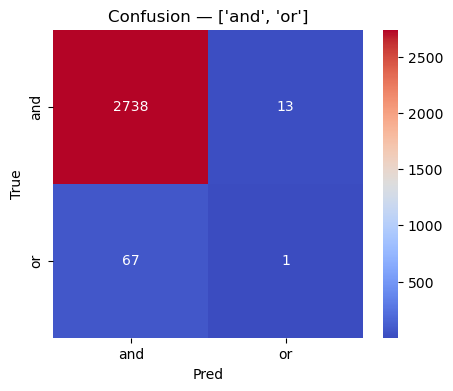


=== Stage 2: learning ['nand', 'nor'] ===
  Epoch 01, loss: 5.0669
  Epoch 10, loss: 2.0586
  Epoch 50, loss: 1.1411
  → Acc group 1 ['and', 'or']: 41.61%
  → Acc group 2 ['nand', 'nor']: 46.92%


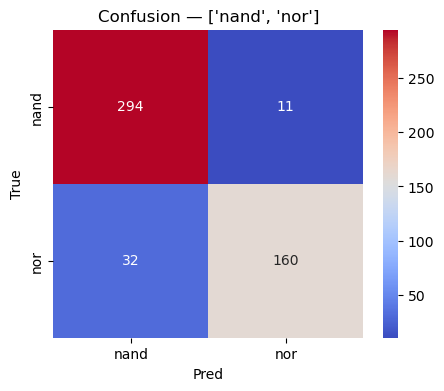


=== Stage 3: learning ['xor'] ===
  Epoch 01, loss: 47.3709
  Epoch 10, loss: 0.9059
  Epoch 50, loss: 0.6292
  → Acc group 1 ['and', 'or']: 43.45%
  → Acc group 2 ['nand', 'nor']: 47.20%
  → Acc group 3 ['xor']: 68.00%


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


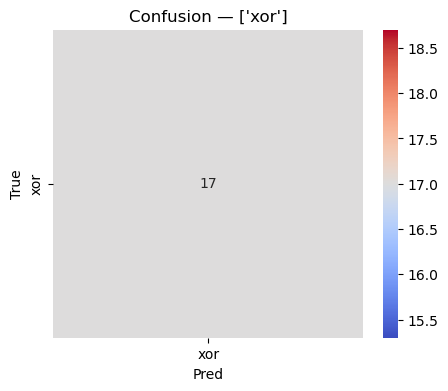


=== Stage 4: learning ['not'] ===
  Epoch 01, loss: 1.0810
  Epoch 10, loss: 0.7467
  Epoch 50, loss: 0.5980
  → Acc group 1 ['and', 'or']: 72.61%
  → Acc group 2 ['nand', 'nor']: 25.14%
  → Acc group 3 ['xor']: 68.00%
  → Acc group 4 ['not']: 83.74%


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


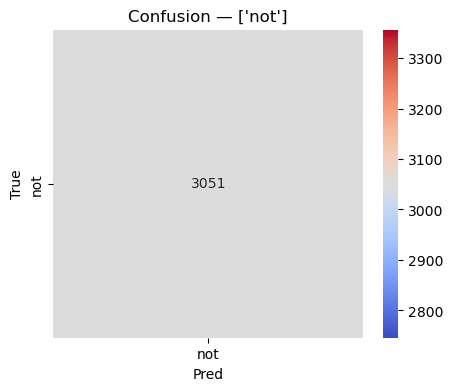


=== Test accuracies per stage & group ===
      group_1 group_2 group_3 group_4
Stage                                
1      72.65%    nan%    nan%    nan%
2      41.61%  46.92%    nan%    nan%
3      43.45%  47.20%  68.00%    nan%
4      72.61%  25.14%  68.00%  83.74%


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import dgl
import dgl.nn as dglnn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------
# 1. Load & preprocess data
# -------------------------
df = pd.read_csv("all_circuits_features.csv")

# encode gate types → integers
le = LabelEncoder()
df["gate_label"] = le.fit_transform(df["gate_type"].astype(str))

# normalize features
feat_cols = [
    "fan_in","fan_out","dist_to_output",
    "is_primary_input","is_primary_output","is_internal","is_key_gate",
    "degree_centrality","betweenness_centrality",
    "closeness_centrality","clustering_coefficient",
    "avg_fan_in_neighbors","avg_fan_out_neighbors"
]
df = df.dropna(subset=feat_cols)
df[feat_cols] = df[feat_cols].astype(float)
df[feat_cols] = StandardScaler().fit_transform(df[feat_cols])

# map node name → index
nodes = df["node"].tolist()
node2idx = {n: i for i, n in enumerate(nodes)}
N = len(nodes)

# -------------------------
# 2. Build DGL graph
# -------------------------
edges = []
src_cands = df[df["fan_out"] > 0]["node"].tolist()
for _, row in df.iterrows():
    tgt = node2idx[row["node"]]
    k   = int(row["fan_in"])
    for s in src_cands[:k]:
        edges.append((node2idx[s], tgt))
edges = list(set(edges))
if edges:
    src, dst = zip(*edges)
else:
    src, dst = [], []
graph = dgl.graph((torch.tensor(src), torch.tensor(dst)), num_nodes=N)
graph = dgl.add_self_loop(graph)
graph.ndata["feat"]  = torch.tensor(df[feat_cols].values, dtype=torch.float32)
graph.ndata["label"] = torch.tensor(df["gate_label"].values, dtype=torch.long)

# -------------------------
# 3. Define tasks by gate groups
# -------------------------
group_defs = [
    ["and","or"],
    ["nand","nor"],
    ["xor","xnor"],
    ["buf","not"]
]
valid_groups = []
train_masks, test_masks = [], []

all_types = set(df["gate_type"])
for grp in group_defs:
    # keep only gates actually in dataset
    present = [g for g in grp if g in all_types]
    if not present:
        continue
    valid_groups.append(present)
    idxs = [node2idx[n] for n in df[df["gate_type"].isin(present)]["node"]]
    tr, te = train_test_split(idxs, test_size=0.2, random_state=42)
    tm = torch.zeros((N,), dtype=torch.bool)
    vm = torch.zeros((N,), dtype=torch.bool)
    tm[tr] = True
    vm[te] = True
    train_masks.append(tm)
    test_masks.append(vm)

# -------------------------
# 4. Define GCN model
# -------------------------
class GCN(nn.Module):
    def __init__(self, in_feats, hid, num_cls):
        super().__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hid, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hid, num_cls, allow_zero_in_degree=True)
    def forward(self, g, x):
        h = torch.relu(self.conv1(g, x))
        return self.conv2(g, h)

# -------------------------
# 5. EWC helper
# -------------------------
class EWC:
    def __init__(self, model, graph, mask, device):
        self.device = device
        self.params = {
            n: p.clone().detach().to(device)
            for n, p in model.named_parameters() if p.requires_grad
        }
        self.fisher = self._compute_fisher(model, graph, mask)

    def _compute_fisher(self, model, graph, mask):
        fisher = {
            n: torch.zeros_like(p, device=self.device)
            for n, p in model.named_parameters() if p.requires_grad
        }
        model.zero_grad()
        logits = model(graph, graph.ndata["feat"].to(self.device))
        logp   = torch.log_softmax(logits, dim=1)
        labels = graph.ndata["label"].to(self.device)
        idxs   = mask.nonzero().squeeze()
        loss   = 0
        for i in idxs:
            i = i.item()
            loss += -logp[i, labels[i]]
        loss = loss / len(idxs)
        loss.backward()
        for n, p in model.named_parameters():
            if p.requires_grad:
                fisher[n] = p.grad.data.clone()**2
        return fisher

    def penalty(self, model):
        loss = 0
        for n, p in model.named_parameters():
            if p.requires_grad:
                loss += (self.fisher[n] * (p - self.params[n])**2).sum()
        return loss

# -------------------------
# 6. Training w/ EWC
# -------------------------
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model      = GCN(len(feat_cols), 64, len(le.classes_)).to(device)
opt        = optim.Adam(model.parameters(), lr=1e-2)
criterion  = nn.CrossEntropyLoss()
graph      = graph.to(device)

ewc_list   = []
lambda_ewc = 1000.0
results    = {}

for stage, (tr_mask, te_mask, grp) in enumerate(
        zip(train_masks, test_masks, valid_groups), start=1):
    print(f"\n=== Stage {stage}: learning {grp} ===")
    tr_mask = tr_mask.to(device)
    te_mask = te_mask.to(device)

    # train current group only
    model.train()
    for epoch in range(1, 51):
        logits   = model(graph, graph.ndata["feat"])
        loss_c   = criterion(logits[tr_mask], graph.ndata["label"][tr_mask])
        if ewc_list:
            pen = sum([m.penalty(model) for m in ewc_list])
            loss = loss_c + (lambda_ewc/2) * pen
        else:
            loss = loss_c

        opt.zero_grad()
        loss.backward()
        opt.step()
        if epoch in (1, 10, 50):
            print(f"  Epoch {epoch:02d}, loss: {loss.item():.4f}")

    # compute Fisher for this task
    ewc_list.append(EWC(model, graph, tr_mask, device))

    # evaluation
    model.eval()
    with torch.no_grad():
        logits = model(graph, graph.ndata["feat"]).cpu().numpy()
        preds  = logits.argmax(axis=1)
        results[stage] = {}
        for i in range(stage):
            mask  = test_masks[i]
            idxs  = mask.nonzero().squeeze().cpu().numpy()
            y_true = graph.ndata["label"][idxs].cpu().numpy()
            y_pred = preds[idxs]
            acc = accuracy_score(y_true, y_pred)
            results[stage][f"group_{i+1}"] = acc
            print(f"  → Acc group {i+1} {valid_groups[i]}: {acc*100:.2f}%")

        # confusion matrix for current group
        cm_idxs = te_mask.nonzero().squeeze().cpu().numpy()
        cm_true = graph.ndata["label"][cm_idxs].cpu().numpy()
        cm_pred = preds[cm_idxs]
        # labels = integer codes of this group's gates
        lbls = le.transform(grp)
        cm = confusion_matrix(cm_true, cm_pred, labels=lbls)
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm",
                    xticklabels=grp, yticklabels=grp)
        plt.title(f"Confusion — {grp}")
        plt.xlabel("Pred"); plt.ylabel("True")
        plt.show()

# -------------------------
# 7. Results summary
# -------------------------
df_res = pd.DataFrame(results).T
df_res.index.name = "Stage"
print("\n=== Test accuracies per stage & group ===")
print(df_res.applymap(lambda v: f"{v*100:5.2f}%"))


##### Interpretability Dashboard

In [21]:
# -------------------------
# 8. Interpretability Dashboard for EWC (Two Plots with Arrows)
# -------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# 8.1 Ensure 'from_to' label exists
if "from_to" not in drift_df.columns:
    drift_df["from_to"] = drift_df.apply(
        lambda r: f"{int(r['from_task'])}→{int(r['to_task'])}", axis=1
    )

# 8.2 Print the drift DataFrame and correlations
print("\n=== EWC Interpretability: Drift vs Forgetting ===")
print(drift_df[["from_to","param_drift","ewc_drift","delta_acc"]])

corr_param = drift_df["param_drift"].corr(drift_df["delta_acc"])
corr_ewc   = drift_df["ewc_drift"].corr(drift_df["delta_acc"])
print(f"\nCorrelation (param drift vs ΔAcc): {corr_param:.4f}")
print(f"Correlation (ewc drift   vs ΔAcc): {corr_ewc:.4f}")


=== EWC Interpretability: Drift vs Forgetting ===
  from_to  param_drift  ewc_drift  delta_acc
0     1→2     7.312001   0.000149   0.310406
1     1→3     9.679255   0.000159   0.291972
2     2→3     5.851059   0.000054  -0.002804
3     1→4     9.930671   0.000149   0.000396
4     2→4     7.207619   0.000086   0.217757
5     3→4     4.193052   0.000002   0.000000

Correlation (param drift vs ΔAcc): 0.3740
Correlation (ewc drift   vs ΔAcc): 0.6096


#### Parameter Regularization: SI


=== Stage 1: learning ['and', 'or'] ===
  Epoch 01, loss: 2.3296
  Epoch 10, loss: 0.9340
  Epoch 50, loss: 0.5331
  → Acc on group 1 ['and', 'or']: 72.90%


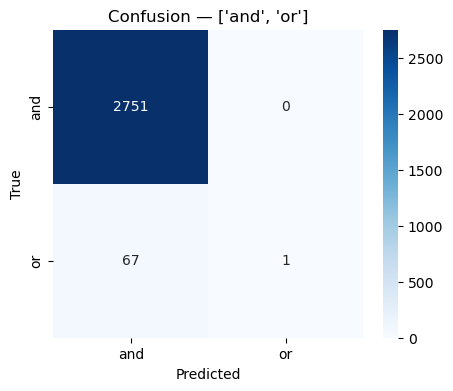


=== Stage 2: learning ['nand', 'nor'] ===
  Epoch 01, loss: 5.0341
  Epoch 10, loss: 4.5619
  Epoch 50, loss: 3.3742
  → Acc on group 1 ['and', 'or']: 72.90%
  → Acc on group 2 ['nand', 'nor']: 8.22%


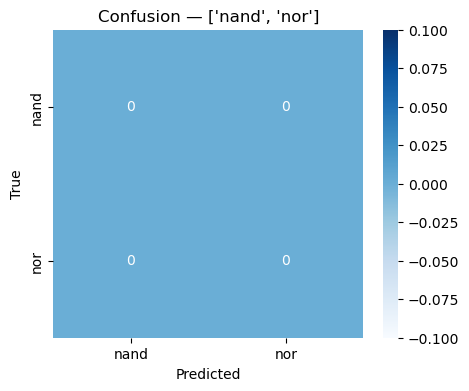


=== Stage 3: learning ['xor'] ===
  Epoch 01, loss: 6.4543
  Epoch 10, loss: -3.1066
  Epoch 50, loss: -853.2559
  → Acc on group 1 ['and', 'or']: 51.77%
  → Acc on group 2 ['nand', 'nor']: 14.95%
  → Acc on group 3 ['xor']: 100.00%


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


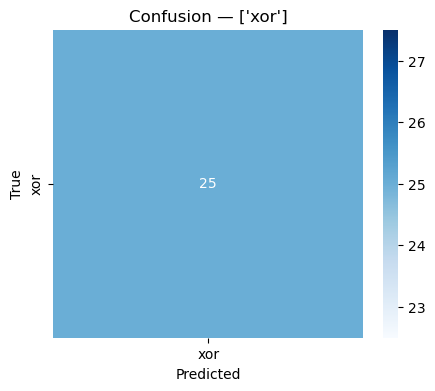


=== Stage 4: learning ['not'] ===
  Epoch 01, loss: 2.8882
  Epoch 10, loss: -93.5667
  Epoch 50, loss: -18180.5918
  → Acc on group 1 ['and', 'or']: 9.18%
  → Acc on group 2 ['nand', 'nor']: 15.14%
  → Acc on group 3 ['xor']: 32.00%
  → Acc on group 4 ['not']: 53.17%


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


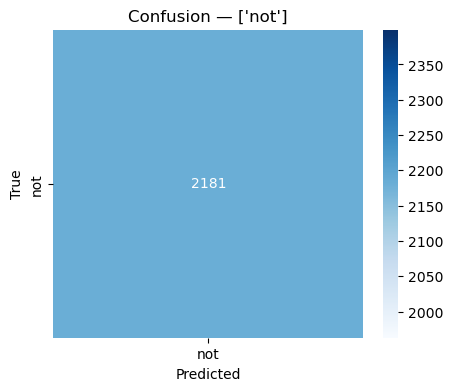


=== Test accuracies per stage & group ===
      group_1 group_2  group_3 group_4
Stage                                 
1      72.90%    nan%     nan%    nan%
2      72.90%   8.22%     nan%    nan%
3      51.77%  14.95%  100.00%    nan%
4       9.18%  15.14%   32.00%  53.17%


In [22]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import dgl
import dgl.nn as dglnn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------
# 1. Load & preprocess data
# ------------------------------------------------
df = pd.read_csv("all_circuits_features.csv")

# encode gate types → integer labels
le = LabelEncoder()
df["gate_label"] = le.fit_transform(df["gate_type"].astype(str))

# normalize features
feat_cols = [
    "fan_in", "fan_out", "dist_to_output",
    "is_primary_input", "is_primary_output",
    "is_internal", "is_key_gate",
    "degree_centrality", "betweenness_centrality",
    "closeness_centrality", "clustering_coefficient",
    "avg_fan_in_neighbors", "avg_fan_out_neighbors"
]
df = df.dropna(subset=feat_cols)
df[feat_cols] = df[feat_cols].astype(float)
df[feat_cols] = StandardScaler().fit_transform(df[feat_cols])

# map node name → index
nodes = df["node"].tolist()
node2idx = {n: i for i, n in enumerate(nodes)}
N = len(nodes)

# ------------------------------------------------
# 2. Build DGL graph once
# ------------------------------------------------
edges = []
src_cands = df[df["fan_out"] > 0]["node"].tolist()
for _, row in df.iterrows():
    tgt = node2idx[row["node"]]
    k   = int(row["fan_in"])
    for s in src_cands[:k]:
        edges.append((node2idx[s], tgt))
edges = list(set(edges))
if edges:
    src, dst = zip(*edges)
else:
    src, dst = [], []
graph = dgl.graph((torch.tensor(src), torch.tensor(dst)), num_nodes=N)
graph = dgl.add_self_loop(graph)
graph.ndata["feat"]  = torch.tensor(df[feat_cols].values, dtype=torch.float32)
graph.ndata["label"] = torch.tensor(df["gate_label"].values, dtype=torch.long)

# ------------------------------------------------
# 3. Define tasks by gate-type groups
# ------------------------------------------------
group_defs = [
    ["and",  "or" ],
    ["nand", "nor"],
    ["xor",  "xnor"],
    ["buf",  "not"]
]
all_types = set(df["gate_type"])
valid_groups, train_masks, test_masks = [], [], []

for grp in group_defs:
    present = [g for g in grp if g in all_types]
    if not present:
        continue
    valid_groups.append(present)
    idxs = [node2idx[n] for n in df[df["gate_type"].isin(present)]["node"]]
    tr, te = train_test_split(idxs, test_size=0.2, random_state=42)
    tm = torch.zeros((N,), dtype=torch.bool)
    vm = torch.zeros((N,), dtype=torch.bool)
    tm[tr] = True; vm[te] = True
    train_masks.append(tm)
    test_masks.append(vm)

# ------------------------------------------------
# 4. Define 2-layer GCN
# ------------------------------------------------
class GCN(nn.Module):
    def __init__(self, in_feats, hid, num_cls):
        super().__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hid, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hid, num_cls, allow_zero_in_degree=True)

    def forward(self, g, x):
        h = torch.relu(self.conv1(g, x))
        return self.conv2(g, h)

# ------------------------------------------------
# 5. Synaptic Intelligence (SI) implementation
# ------------------------------------------------
class SynapticIntelligence:
    def __init__(self, model, xi=0.1):
        self.xi = xi
        # total importance ω_i
        self.omega = {
            n: torch.zeros_like(p.data) 
            for n, p in model.named_parameters() if p.requires_grad
        }
        # snapshot of parameters after last task
        self.theta_old = {
            n: p.data.clone().detach() 
            for n, p in model.named_parameters() if p.requires_grad
        }

    def begin_task(self, model):
        # snapshot at start of new task
        self.prev_theta = {
            n: p.data.clone().detach() 
            for n, p in model.named_parameters() if p.requires_grad
        }
        # path integral accumulator
        self.path_omega = {
            n: torch.zeros_like(p.data) 
            for n, p in model.named_parameters() if p.requires_grad
        }

    def accumulate(self, model):
        # call after backward() before optimizer.step()
        for n, p in model.named_parameters():
            if not p.requires_grad: continue
            grad = p.grad.data
            delta = (p.data - self.prev_theta[n])
            self.path_omega[n] += - grad * delta
            # update prev_theta for next step
            self.prev_theta[n] = p.data.clone().detach()

    def end_task(self, model):
        # compute and accumulate omega for this task
        for n, p in model.named_parameters():
            if not p.requires_grad: continue
            delta = p.data - self.theta_old[n]
            # avoid division by zero
            denom = delta.pow(2) + self.xi
            omega_task = self.path_omega[n] / denom
            self.omega[n] += omega_task
            # update theta_old for next tasks
            self.theta_old[n] = p.data.clone().detach()

    def penalty(self, model):
        # regularization loss Σ ω_i (θ_i - θ_old_i)²
        loss = 0
        for n, p in model.named_parameters():
            if not p.requires_grad: continue
            loss += (self.omega[n] * (p - self.theta_old[n]).pow(2)).sum()
        return loss

# ------------------------------------------------
# 6. Training loop w/ SI regularization
# ------------------------------------------------
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model      = GCN(in_feats=len(feat_cols), hid=64, num_cls=len(le.classes_)).to(device)
opt        = optim.Adam(model.parameters(), lr=1e-2)
criterion  = nn.CrossEntropyLoss()
graph      = graph.to(device)

si = SynapticIntelligence(model, xi=0.1)
lambda_si = 1000.0
results    = {}
# Before the training loop, initialize lists to hold per‐task snapshots
theta_snapshots = []
omega_snapshots = []

for stage, (tr_mask, te_mask, grp) in enumerate(
        zip(train_masks, test_masks, valid_groups), start=1):
    print(f"\n=== Stage {stage}: learning {grp} ===")
    tr_mask = tr_mask.to(device)
    te_mask = te_mask.to(device)

    # prepare SI
    si.begin_task(model)

    # train current task only
    model.train()
    for epoch in range(1, 51):
        logits = model(graph, graph.ndata["feat"])
        loss_c = criterion(logits[tr_mask], graph.ndata["label"][tr_mask])
        # add SI regularization from previous tasks
        if stage > 1:
            loss = loss_c + lambda_si * si.penalty(model)
        else:
            loss = loss_c

        opt.zero_grad()
        loss.backward()
        # accumulate path‐integral
        si.accumulate(model)
        opt.step()

        if epoch in (1, 10, 50):
            print(f"  Epoch {epoch:02d}, loss: {loss.item():.4f}")

    # finish SI for this task
    si.end_task(model)
    
    # ------------------------------------------------------------
    # After finishing task `stage`, snapshot θ_old and Ω
    theta_snapshots.append({
        name: tensor.clone().detach().cpu()
        for name, tensor in si.theta_old.items()
    })
    omega_snapshots.append({
        name: tensor.clone().detach().cpu()
        for name, tensor in si.omega.items()
    })
    # ------------------------------------------------------------

    # evaluate on all seen tasks
    model.eval()
    with torch.no_grad():
        logits = model(graph, graph.ndata["feat"]).cpu().numpy()
        preds  = logits.argmax(axis=1)
        results[stage] = {}
        for i in range(stage):
            mask  = test_masks[i]
            idxs  = mask.nonzero().squeeze().cpu().numpy()
            y_true = graph.ndata["label"][idxs].cpu().numpy()
            y_pred = preds[idxs]
            acc = accuracy_score(y_true, y_pred)
            results[stage][f"group_{i+1}"] = acc
            print(f"  → Acc on group {i+1} {valid_groups[i]}: {acc*100:.2f}%")

        # confusion matrix for current group
        cm_idxs = te_mask.nonzero().squeeze().cpu().numpy()
        cm_true = graph.ndata["label"][cm_idxs].cpu().numpy()
        cm_pred = preds[cm_idxs]
        lbls = le.transform(grp)
        cm = confusion_matrix(cm_true, cm_pred, labels=lbls)
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=grp, yticklabels=grp)
        plt.title(f"Confusion — {grp}")
        plt.xlabel("Predicted"); plt.ylabel("True")
        plt.show()

# ------------------------------------------------
# 7. Summary of results
# ------------------------------------------------
df_res = pd.DataFrame(results).T
df_res.index.name = "Stage"
print("\n=== Test accuracies per stage & group ===")
print(df_res.applymap(lambda v: f"{v*100:5.2f}%"))


##### Interpretability Dashboard

In [23]:
# -------------------------
# 8. Interpretability Dashboard for SI
# -------------------------
import pandas as pd
import numpy as np

# Build a table of drifts and forgetting
records = []
num_tasks = len(theta_snapshots)
for t in range(2, num_tasks + 1):
    θ_t = theta_snapshots[t - 1]
    for k in range(1, t):
        θ_k = theta_snapshots[k - 1]
        Ω_k = omega_snapshots[k - 1]

        # 1) L2 parameter drift ‖θ^(t) − θ^(k)‖₂
        sq = 0.0
        for name in θ_k:
            d = (θ_t[name] - θ_k[name])
            sq += (d.pow(2)).sum().item()
        param_drift = np.sqrt(sq)

        # 2) SI-weighted drift Σ Ω_i^(k) · (Δθ_i)²
        si_drift = 0.0
        for name in θ_k:
            d = (θ_t[name] - θ_k[name])
            si_drift += (Ω_k[name] * d.pow(2)).sum().item()

        # 3) Forgetting ΔAcc = Acc_k(k) − Acc_k(t)
        acc_kk = results[k][f"group_{k}"]
        acc_kt = results[t][f"group_{k}"]
        delta_acc = acc_kk - acc_kt

        records.append({
            "from_task": k,
            "to_task":   t,
            "param_drift": param_drift,
            "si_drift":    si_drift,
            "delta_acc":   delta_acc
        })

si_df = pd.DataFrame(records)
si_df["from_to"] = si_df.apply(lambda r: f"{int(r['from_task'])}→{int(r['to_task'])}", axis=1)

# Print the SI interpretability table
print("\n=== SI Interpretability: Drift vs Forgetting ===")
print(si_df[["from_to","param_drift","si_drift","delta_acc"]])

# Compute correlations
corr_param = si_df["param_drift"].corr(si_df["delta_acc"])
corr_si    = si_df["si_drift"].corr(si_df["delta_acc"])
print(f"\nCorrelation (param drift vs ΔAcc):        {corr_param:.4f}")
print(f"Correlation (SI-weighted drift vs ΔAcc):  {corr_si:.4f}")

# (Optional) Scatterplots can be added similarly to EWC but are omitted per request.



=== SI Interpretability: Drift vs Forgetting ===
  from_to  param_drift   si_drift  delta_acc
0     1→2     2.149134  -0.000320   0.000000
1     1→3    17.742040   1.680352   0.211298
2     2→3    17.557760  -0.896844  -0.067290
3     1→4    24.167522   3.648412   0.637265
4     2→4    24.042354   3.172229  -0.069159
5     3→4    16.448309 -19.025906   0.680000

Correlation (param drift vs ΔAcc):        0.2732
Correlation (SI-weighted drift vs ΔAcc):  -0.5234


#### Replay-based Methods (a.k.a. Experience Replay):iCaRL (Incremental Classifier and Representation Learning)


=== Stage 1: learning ['and', 'or'] ===
  Epoch 01, loss: 2.0354
  Epoch 10, loss: 0.7963
  Epoch 50, loss: 0.5279
  → Acc on group 1 ['and', 'or']: 72.88%


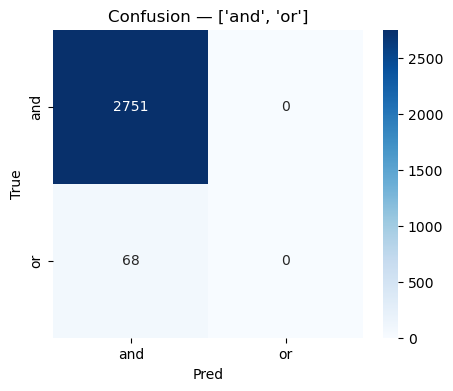


=== Stage 2: learning ['nand', 'nor'] ===
  Epoch 01, loss: 5.2293
  Epoch 10, loss: 2.1330
  Epoch 50, loss: 1.3641
  → Acc on group 1 ['and', 'or']: 82.81%
  → Acc on group 2 ['nand', 'nor']: 47.57%


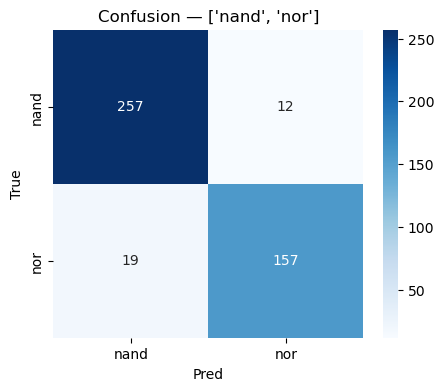


=== Stage 3: learning ['xor'] ===
  Epoch 01, loss: 15.5082
  Epoch 10, loss: 0.8797
  Epoch 50, loss: 0.7880
  → Acc on group 1 ['and', 'or']: 82.08%
  → Acc on group 2 ['nand', 'nor']: 49.25%
  → Acc on group 3 ['xor']: 68.00%


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


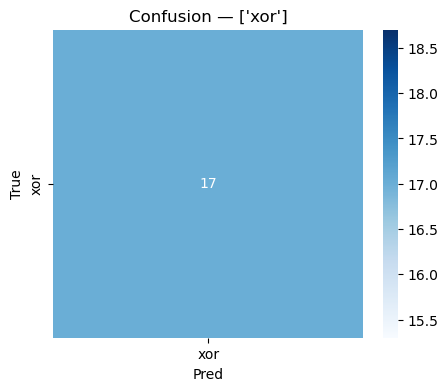


=== Stage 4: learning ['not'] ===
  Epoch 01, loss: 0.6145
  Epoch 10, loss: 0.5766
  Epoch 50, loss: 0.4833
  → Acc on group 1 ['and', 'or']: 69.81%
  → Acc on group 2 ['nand', 'nor']: 47.94%
  → Acc on group 3 ['xor']: 68.00%
  → Acc on group 4 ['not']: 83.66%


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


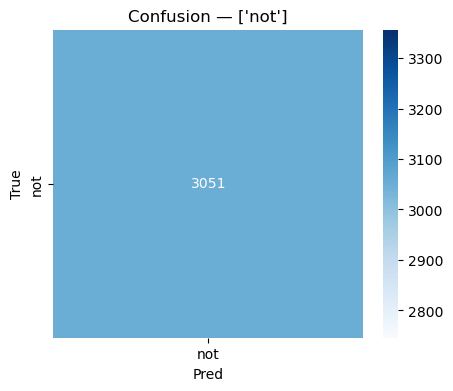


=== Test accuracies per stage & group ===
      group_1 group_2 group_3 group_4
Stage                                
1      72.88%    nan%    nan%    nan%
2      82.81%  47.57%    nan%    nan%
3      82.08%  49.25%  68.00%    nan%
4      69.81%  47.94%  68.00%  83.66%


In [24]:
import copy
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import dgl
import dgl.nn as dglnn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------
# 1. Load & preprocess data
# ------------------------------------------------
df = pd.read_csv("all_circuits_features.csv")

# encode gate types → integer labels
le = LabelEncoder()
df["gate_label"] = le.fit_transform(df["gate_type"].astype(str))

# normalize features
feat_cols = [
    "fan_in","fan_out","dist_to_output",
    "is_primary_input","is_primary_output","is_internal","is_key_gate",
    "degree_centrality","betweenness_centrality",
    "closeness_centrality","clustering_coefficient",
    "avg_fan_in_neighbors","avg_fan_out_neighbors"
]
df = df.dropna(subset=feat_cols)
df[feat_cols] = StandardScaler().fit_transform(df[feat_cols].astype(float))

# map node names → indices
nodes = df["node"].tolist()
node2idx = {n: i for i, n in enumerate(nodes)}
N = len(nodes)

# ------------------------------------------------
# 2. Build single DGL graph
# ------------------------------------------------
edges = []
src_cands = df[df["fan_out"] > 0]["node"].tolist()
for _, row in df.iterrows():
    tgt = node2idx[row["node"]]
    k   = int(row["fan_in"])
    for s in src_cands[:k]:
        edges.append((node2idx[s], tgt))
edges = list(set(edges))
src, dst = zip(*edges) if edges else ([], [])
g = dgl.graph((torch.tensor(src), torch.tensor(dst)), num_nodes=N)
g = dgl.add_self_loop(g)
g.ndata["feat"]  = torch.tensor(df[feat_cols].values, dtype=torch.float32)
g.ndata["label"] = torch.tensor(df["gate_label"].values, dtype=torch.long)

# ------------------------------------------------
# 3. Define tasks by gate‐type groups
# ------------------------------------------------
group_defs = [
    ["and","or"],
    ["nand","nor"],
    ["xor","xnor"],
    ["buf","not"]
]
all_types = set(df["gate_type"])
valid_groups, train_masks, test_masks = [], [], []
for grp in group_defs:
    present = [g for g in grp if g in all_types]
    if not present:
        continue
    valid_groups.append(present)
    idxs = [node2idx[n] for n in df[df["gate_type"].isin(present)]["node"]]
    tr, te = train_test_split(idxs, test_size=0.2, random_state=42)
    tm = torch.zeros(N, dtype=torch.bool); tm[tr] = True
    vm = torch.zeros(N, dtype=torch.bool); vm[te] = True
    train_masks.append(tm); test_masks.append(vm)

# ------------------------------------------------
# 4. 2‐layer GCN model
# ------------------------------------------------
class GCN(nn.Module):
    def __init__(self, in_feats, hid, num_cls):
        super().__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hid, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hid,   num_cls, allow_zero_in_degree=True)
    def forward(self, graph, x):
        h = F.relu(self.conv1(graph, x))
        return self.conv2(graph, h)

# ------------------------------------------------
# 5. iCaRL‐style replay + distillation
# ------------------------------------------------
memory_per_class = 20       # exemplars per class
temperature      = 2.0
lambda_distill   = 1.0
kl_loss          = nn.KLDivLoss(reduction='batchmean')

# store exemplars: mapping from class_label → list of node indices
exemplar_sets = {}

def update_exemplars(class_label, candidate_idxs):
    """ Randomly pick up to memory_per_class exemplars for class_label """
    np.random.shuffle(candidate_idxs)
    exemplar_sets[class_label] = candidate_idxs[:memory_per_class]

def get_all_exemplars():
    """ Flatten all stored exemplar indices """
    return [idx for idxs in exemplar_sets.values() for idx in idxs]

# ------------------------------------------------
# 6. Training loop w/ iCaRL‐style replay
# ------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = GCN(len(feat_cols), 64, len(le.classes_)).to(device)
opt    = optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()
g = g.to(device)

results = {}
old_model = None  # for distillation

for stage, (tr_mask, te_mask, grp) in enumerate(
        zip(train_masks, test_masks, valid_groups), start=1):
    print(f"\n=== Stage {stage}: learning {grp} ===")
    tr_mask = tr_mask.to(device)
    te_mask = te_mask.to(device)

    # BEFORE training: keep a frozen copy for distillation
    if stage > 1:
        old_model = copy.deepcopy(model).eval().to(device)

    # combine new‐task indices + exemplars
    new_idxs      = tr_mask.nonzero().squeeze().tolist()
    exemplar_idxs = get_all_exemplars()
    train_idxs    = new_idxs + exemplar_idxs
    train_idxs_t  = torch.tensor(train_idxs, dtype=torch.long, device=device)

    # precompute soft‐targets for exemplars
    if old_model:
        with torch.no_grad():
            old_logits = old_model(g, g.ndata["feat"])
            old_soft   = F.softmax(old_logits[exemplar_idxs] / temperature, dim=1)

    # TRAIN for 50 epochs
    model.train()
    for epoch in range(1, 51):
        logits = model(g, g.ndata["feat"])
        # cross‐entropy on combined set
        ce_loss = criterion(logits[train_idxs_t],
                            g.ndata["label"][train_idxs_t])
        # distillation on exemplars only
        if old_model and exemplar_idxs:
            cur_logp = F.log_softmax(
                logits[exemplar_idxs] / temperature, dim=1
            )
            distill_loss = kl_loss(cur_logp, old_soft) * (temperature**2)
            loss = ce_loss + lambda_distill * distill_loss
        else:
            loss = ce_loss

        opt.zero_grad()
        loss.backward()
        opt.step()
        if epoch in (1, 10, 50):
            print(f"  Epoch {epoch:02d}, loss: {loss.item():.4f}")

    # AFTER training: update exemplars for each new class
    for gate in grp:
        cls = le.transform([gate])[0]
        cand_idxs = [idx for idx in new_idxs
                     if g.ndata["label"][idx].item() == cls]
        update_exemplars(cls, cand_idxs)

    # EVALUATION on all seen tasks
    model.eval()
    with torch.no_grad():
        logits = model(g, g.ndata["feat"]).cpu().numpy()
        preds  = logits.argmax(axis=1)
        results[stage] = {}
        for i in range(stage):
            mask  = test_masks[i]
            idxs  = mask.nonzero().squeeze().cpu().numpy()
            y_true = g.ndata["label"][idxs].cpu().numpy()
            y_pred = preds[idxs]
            acc = accuracy_score(y_true, y_pred)
            results[stage][f"group_{i+1}"] = acc
            print(f"  → Acc on group {i+1} {valid_groups[i]}: {acc*100:.2f}%")

        # confusion matrix for current group
        cm_idxs = te_mask.nonzero().squeeze().cpu().numpy()
        cm = confusion_matrix(
            g.ndata["label"][cm_idxs].cpu().numpy(),
            preds[cm_idxs],
            labels=[le.transform([g])[0] for g in grp]
        )
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=grp, yticklabels=grp)
        plt.title(f"Confusion — {grp}")
        plt.xlabel("Pred"); plt.ylabel("True")
        plt.show()

# ------------------------------------------------
# 7. Summarize results
# ------------------------------------------------
df_res = pd.DataFrame(results).T
df_res.index.name = "Stage"
print("\n=== Test accuracies per stage & group ===")
print(df_res.applymap(lambda v: f"{v*100:5.2f}%"))


##### Interpretability Dashboard


=== Stage 1: learning ['and', 'or'] ===
  Epoch 01, loss: 2.1165
  Epoch 10, loss: 0.8797
  Epoch 50, loss: 0.5307
  → Acc group 1 ['and', 'or']: 72.88%


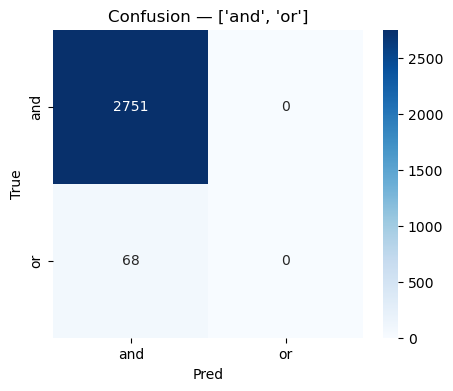


=== Stage 2: learning ['nand', 'nor'] ===
  Epoch 01, loss: 5.2155
  Epoch 10, loss: 2.4067
  Epoch 50, loss: 1.3066
  → Acc group 1 ['and', 'or']: 82.40%
  → Acc group 2 ['nand', 'nor']: 48.13%


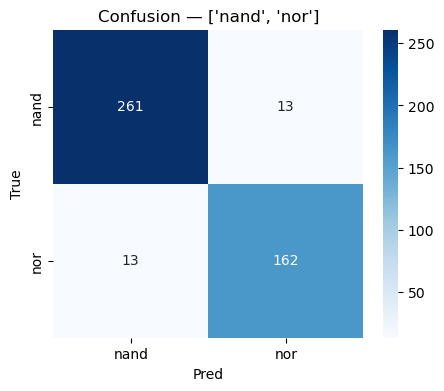


=== Stage 3: learning ['xor'] ===
  Epoch 01, loss: 11.2446
  Epoch 10, loss: 0.9619
  Epoch 50, loss: 0.8494
  → Acc group 1 ['and', 'or']: 75.00%
  → Acc group 2 ['nand', 'nor']: 70.84%
  → Acc group 3 ['xor']: 68.00%


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


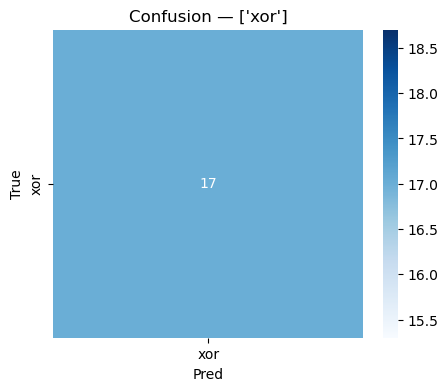


=== Stage 4: learning ['not'] ===
  Epoch 01, loss: 0.6370
  Epoch 10, loss: 0.5873
  Epoch 50, loss: 0.4778
  → Acc group 1 ['and', 'or']: 69.30%
  → Acc group 2 ['nand', 'nor']: 48.88%
  → Acc group 3 ['xor']: 68.00%
  → Acc group 4 ['not']: 83.52%


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


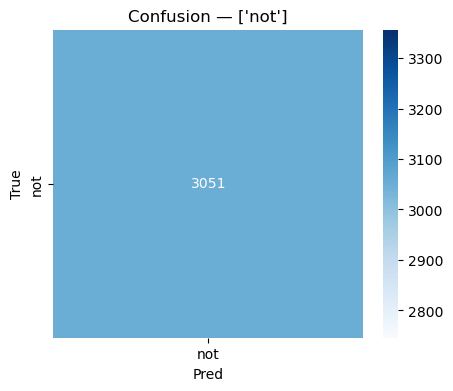


=== Test accuracies per stage & group ===
      group_1 group_2 group_3 group_4
Stage                                
1      72.88%    nan%    nan%    nan%
2      82.40%  48.13%    nan%    nan%
3      75.00%  70.84%  68.00%    nan%
4      69.30%  48.88%  68.00%  83.52%

=== iCaRL Interpretability: Drift vs Forgetting ===
  from_to  param_drift  distill_loss  delta_acc
0     1→2     7.025989     35.700325  -0.095144
1     1→3     9.031317     52.073387  -0.021209
2     2→3     4.966096      6.127798  -0.227103
3     1→4     9.297355     57.026020   0.035877
4     2→4     5.567279      7.540477  -0.007477
5     3→4     2.283744      1.368736   0.000000

Correlation (param drift vs ΔAcc):   0.2421
Correlation (distill loss vs ΔAcc):   0.3779


In [30]:
import copy
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import dgl
import dgl.nn as dglnn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------
# 1. Load & preprocess data
# ------------------------------------------------
df = pd.read_csv("all_circuits_features.csv")
le = LabelEncoder()
df["gate_label"] = le.fit_transform(df["gate_type"].astype(str))

feat_cols = [
    "fan_in","fan_out","dist_to_output",
    "is_primary_input","is_primary_output","is_internal","is_key_gate",
    "degree_centrality","betweenness_centrality",
    "closeness_centrality","clustering_coefficient",
    "avg_fan_in_neighbors","avg_fan_out_neighbors"
]
df = df.dropna(subset=feat_cols)
df[feat_cols] = StandardScaler().fit_transform(df[feat_cols].astype(float))

nodes = df["node"].tolist()
node2idx = {n: i for i, n in enumerate(nodes)}
N = len(nodes)

# ------------------------------------------------
# 2. Build single DGL graph
# ------------------------------------------------
edges = []
src_cands = df[df["fan_out"] > 0]["node"].tolist()
for _, row in df.iterrows():
    tgt = node2idx[row["node"]]
    for s in src_cands[: int(row["fan_in"])]:
        edges.append((node2idx[s], tgt))
edges = list(set(edges))
src, dst = zip(*edges) if edges else ([], [])
g = dgl.graph((torch.tensor(src), torch.tensor(dst)), num_nodes=N)
g = dgl.add_self_loop(g)
g.ndata["feat"]  = torch.tensor(df[feat_cols].values, dtype=torch.float32)
g.ndata["label"] = torch.tensor(df["gate_label"].values, dtype=torch.long)

# ------------------------------------------------
# 3. Define tasks by gate‐type groups
# ------------------------------------------------
group_defs = [
    ["and","or"],
    ["nand","nor"],
    ["xor","xnor"],
    ["buf","not"]
]
all_types = set(df["gate_type"])
valid_groups, train_masks, test_masks = [], [], []
for grp in group_defs:
    present = [gtype for gtype in grp if gtype in all_types]
    if not present:
        continue
    valid_groups.append(present)
    idxs = [node2idx[n] for n in df[df["gate_type"].isin(present)]["node"]]
    tr, te = train_test_split(idxs, test_size=0.2, random_state=42)
    tm = torch.zeros((N,), dtype=torch.bool); tm[tr] = True
    vm = torch.zeros((N,), dtype=torch.bool); vm[te] = True
    train_masks.append(tm); test_masks.append(vm)

# ------------------------------------------------
# 4. Define 2‐layer GCN model
# ------------------------------------------------
class GCN(nn.Module):
    def __init__(self, in_feats, hid, num_cls):
        super().__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hid, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hid,   num_cls, allow_zero_in_degree=True)
    def forward(self, graph, x):
        h = F.relu(self.conv1(graph, x))
        return self.conv2(graph, h)

# ------------------------------------------------
# 5. iCaRL‐style replay + distillation setup
# ------------------------------------------------
memory_per_class = 20
temperature      = 2.0
lambda_distill   = 1.0
kl_loss          = nn.KLDivLoss(reduction='batchmean')
exemplar_sets    = {}

def update_exemplars(cls, cand_idxs):
    np.random.shuffle(cand_idxs)
    exemplar_sets[cls] = cand_idxs[:memory_per_class]

def get_all_exemplars():
    return [idx for idxs in exemplar_sets.values() for idx in idxs]

# ------------------------------------------------
# 6. Training loop w/ iCaRL + snapshot collection
# ------------------------------------------------
device            = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model             = GCN(len(feat_cols), 64, len(le.classes_)).to(device)
opt               = optim.Adam(model.parameters(), lr=1e-2)
criterion         = nn.CrossEntropyLoss()
g                 = g.to(device)
results           = {}
param_snapshots   = []   # list of state_dicts (CPU tensors)
logits_snapshots  = []   # list of logits (N×C) after each stage
memory_snapshots  = []   # list of exemplar idx lists after each stage
old_model         = None

for stage, (tr_mask, te_mask, grp) in enumerate(
        zip(train_masks, test_masks, valid_groups), start=1):
    print(f"\n=== Stage {stage}: learning {grp} ===")
    tr_mask = tr_mask.to(device)
    te_mask = te_mask.to(device)
    new_idxs = tr_mask.nonzero().squeeze().tolist()

    # frozen copy for distillation
    if stage > 1:
        old_model = copy.deepcopy(model).eval().to(device)

    exemplar_idxs = get_all_exemplars()
    train_idxs    = new_idxs + exemplar_idxs
    train_idxs_t  = torch.tensor(train_idxs, dtype=torch.long, device=device)

    if old_model and exemplar_idxs:
        with torch.no_grad():
            old_logits = old_model(g, g.ndata["feat"])
            old_soft   = F.softmax(old_logits[exemplar_idxs] / temperature, dim=1)

    model.train()
    for epoch in range(1, 51):
        logits_out = model(g, g.ndata["feat"])
        ce_loss    = criterion(logits_out[train_idxs_t], g.ndata["label"][train_idxs_t])
        if old_model and exemplar_idxs:
            cur_logp      = F.log_softmax(logits_out[exemplar_idxs]/temperature, dim=1)
            distill_loss = kl_loss(cur_logp, old_soft) * (temperature**2)
            loss         = ce_loss + lambda_distill * distill_loss
        else:
            loss = ce_loss

        opt.zero_grad()
        loss.backward()
        opt.step()
        if epoch in (1, 10, 50):
            print(f"  Epoch {epoch:02d}, loss: {loss.item():.4f}")

    # update exemplars
    for gate in grp:
        cls = le.transform([gate])[0]
        cand_idxs = [i for i in new_idxs if g.ndata["label"][i].item() == cls]
        update_exemplars(cls, cand_idxs)

    # evaluation
    model.eval()
    with torch.no_grad():
        logits_full = model(g, g.ndata["feat"]).cpu()
        preds       = logits_full.argmax(dim=1).numpy()
        results[stage] = {}
        for i in range(stage):
            idxs = test_masks[i].nonzero().squeeze().cpu().numpy()
            y_true = g.ndata["label"][idxs].cpu().numpy()
            y_pred = preds[idxs]
            acc     = accuracy_score(y_true, y_pred)
            results[stage][f"group_{i+1}"] = acc
            print(f"  → Acc group {i+1} {valid_groups[i]}: {acc*100:.2f}%")

        cm = confusion_matrix(
            g.ndata["label"][te_mask].cpu().numpy(),
            preds[te_mask.nonzero().squeeze().cpu().numpy()],
            labels=[le.transform([gtype])[0] for gtype in grp]
        )
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=grp, yticklabels=grp)
        plt.title(f"Confusion — {grp}")
        plt.xlabel("Pred"); plt.ylabel("True")
        plt.show()

    # snapshots after stage
    param_snapshots.append({
        name: tensor.clone().detach().cpu()
        for name, tensor in model.state_dict().items()
    })
    logits_snapshots.append(logits_full)
    memory_snapshots.append(list(get_all_exemplars()))

# ------------------------------------------------
# 7. Summarize results
# ------------------------------------------------
df_res = pd.DataFrame(results).T
df_res.index.name = "Stage"
print("\n=== Test accuracies per stage & group ===")
print(df_res.applymap(lambda v: f"{v*100:5.2f}%"))

# ------------------------------------------------
# 8. Interpretability Dashboard for iCaRL
# ------------------------------------------------
records = []
num_tasks = len(param_snapshots)

for t in range(2, num_tasks + 1):
    state_t  = param_snapshots[t-1]
    logits_t = logits_snapshots[t-1]
    for k in range(1, t):
        state_k   = param_snapshots[k-1]
        logits_k  = logits_snapshots[k-1]
        M_k       = memory_snapshots[k-1]
        N_k       = len(M_k)

        # parameter drift
        sq = 0.0
        for name in state_k:
            d = state_t[name] - state_k[name]
            sq += d.pow(2).sum().item()
        param_drift = np.sqrt(sq)

        # distillation loss
        if N_k > 0:
            diffs = logits_t[M_k] - logits_k[M_k]
            distill_loss = diffs.pow(2).sum(dim=1).mean().item()
        else:
            distill_loss = np.nan

        # forgetting
        acc_kk = results[k][f"group_{k}"]
        acc_kt = results[t][f"group_{k}"]
        delta_acc = acc_kk - acc_kt

        records.append({
            "from_task":    k,
            "to_task":      t,
            "param_drift":  param_drift,
            "distill_loss": distill_loss,
            "delta_acc":    delta_acc
        })

ica_df = pd.DataFrame(records)
ica_df["from_to"] = ica_df.apply(lambda r: f"{int(r['from_task'])}→{int(r['to_task'])}", axis=1)

print("\n=== iCaRL Interpretability: Drift vs Forgetting ===")
print(ica_df[["from_to","param_drift","distill_loss","delta_acc"]])

corr_param   = ica_df["param_drift"].corr(ica_df["delta_acc"])
corr_distill = ica_df["distill_loss"].corr(ica_df["delta_acc"])
print(f"\nCorrelation (param drift vs ΔAcc):   {corr_param:.4f}")
print(f"Correlation (distill loss vs ΔAcc):   {corr_distill:.4f}")


#### Replay-based Methods (a.k.a. Experience Replay): A-GEM (Average Gradient Episodic Memory)


=== Stage 1: learning ['and', 'or'] ===
  Epoch 01, loss_new: 2.1566
  Epoch 10, loss_new: 0.8697
  Epoch 50, loss_new: 0.5311
  → Acc on group 1 ['and', 'or']: 72.86%


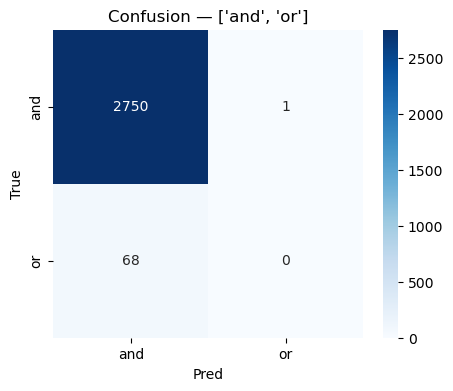


=== Stage 2: learning ['nand', 'nor'] ===
  Epoch 01, loss_new: 6.0145
  Epoch 10, loss_new: 2.2210
  Epoch 50, loss_new: 0.9236
  → Acc on group 1 ['and', 'or']: 73.80%
  → Acc on group 2 ['nand', 'nor']: 49.63%


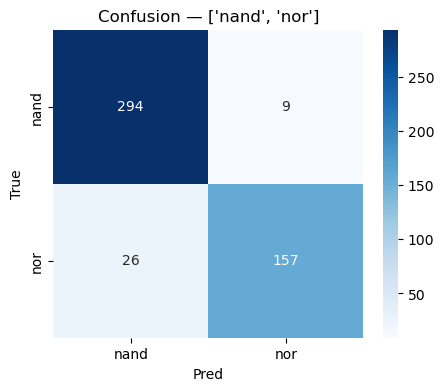


=== Stage 3: learning ['xor'] ===
  Epoch 01, loss_new: 23.5245
  Epoch 10, loss_new: 0.5749
  Epoch 50, loss_new: 0.4614
  → Acc on group 1 ['and', 'or']: 80.06%
  → Acc on group 2 ['nand', 'nor']: 49.91%
  → Acc on group 3 ['xor']: 68.00%


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


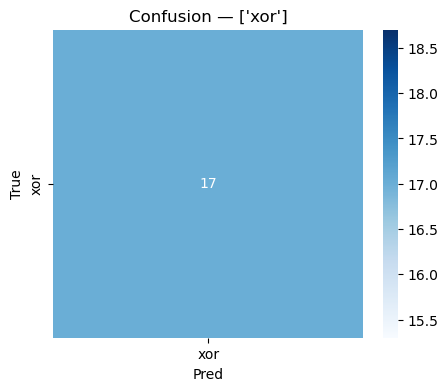


=== Stage 4: learning ['not'] ===
  Epoch 01, loss_new: 0.6577
  Epoch 10, loss_new: 0.5427
  Epoch 50, loss_new: 0.4403
  → Acc on group 1 ['and', 'or']: 83.35%
  → Acc on group 2 ['nand', 'nor']: 49.53%
  → Acc on group 3 ['xor']: 68.00%
  → Acc on group 4 ['not']: 78.48%


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


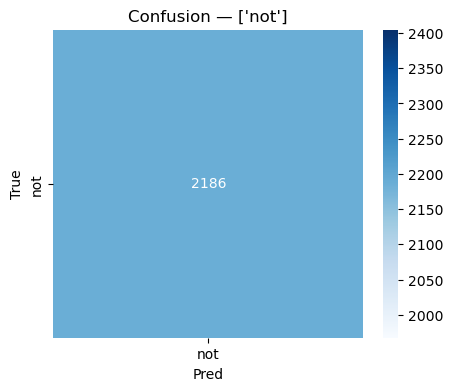


=== Test accuracies per stage & group ===
      group_1 group_2 group_3 group_4
Stage                                
1      72.86%    nan%    nan%    nan%
2      73.80%  49.63%    nan%    nan%
3      80.06%  49.91%  68.00%    nan%
4      83.35%  49.53%  68.00%  78.48%


In [31]:
import copy
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import dgl
import dgl.nn as dglnn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------
# 1. Load & preprocess data
# ------------------------------------------------
df = pd.read_csv("all_circuits_features.csv")
le = LabelEncoder()
df["gate_label"] = le.fit_transform(df["gate_type"].astype(str))

feat_cols = [
    "fan_in","fan_out","dist_to_output",
    "is_primary_input","is_primary_output","is_internal","is_key_gate",
    "degree_centrality","betweenness_centrality",
    "closeness_centrality","clustering_coefficient",
    "avg_fan_in_neighbors","avg_fan_out_neighbors"
]
df = df.dropna(subset=feat_cols)
df[feat_cols] = StandardScaler().fit_transform(df[feat_cols].astype(float))

nodes = df["node"].tolist()
node2idx = {n:i for i,n in enumerate(nodes)}
N = len(nodes)

# ------------------------------------------------
# 2. Build DGL graph
# ------------------------------------------------
edges = []
src_cands = df[df["fan_out"]>0]["node"].tolist()
for _, row in df.iterrows():
    tgt = node2idx[row["node"]]
    for s in src_cands[:int(row["fan_in"])]:
        edges.append((node2idx[s], tgt))
edges = list(set(edges))
src, dst = zip(*edges) if edges else ([],[])
graph = dgl.graph((torch.tensor(src), torch.tensor(dst)), num_nodes=N)
graph = dgl.add_self_loop(graph)
graph.ndata["feat"]  = torch.tensor(df[feat_cols].values, dtype=torch.float32)
graph.ndata["label"] = torch.tensor(df["gate_label"].values, dtype=torch.long)

# ------------------------------------------------
# 3. Define tasks by gate‐type groups
# ------------------------------------------------
group_defs = [
    ["and","or"],
    ["nand","nor"],
    ["xor","xnor"],
    ["buf","not"]
]
all_types = set(df["gate_type"])
valid_groups, train_masks, test_masks = [], [], []
for grp in group_defs:
    present = [g for g in grp if g in all_types]
    if not present: continue
    valid_groups.append(present)
    idxs = [node2idx[n] for n in df[df["gate_type"].isin(present)]["node"]]
    tr, te = train_test_split(idxs, test_size=0.2, random_state=42)
    tm = torch.zeros((N,), dtype=torch.bool); tm[tr]=True
    vm = torch.zeros((N,), dtype=torch.bool); vm[te]=True
    train_masks.append(tm); test_masks.append(vm)

# ------------------------------------------------
# 4. Define GCN
# ------------------------------------------------
class GCN(nn.Module):
    def __init__(self, in_feats, hid, num_cls):
        super().__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hid, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hid,   num_cls, allow_zero_in_degree=True)
    def forward(self, g, x):
        h = torch.relu(self.conv1(g, x))
        return self.conv2(g, h)

# ------------------------------------------------
# 5. Helper: flatten & set grads
# ------------------------------------------------
def get_grad_vector(params):
    return torch.cat([p.grad.data.view(-1) for p in params])

def set_grad_vector(params, vec):
    pointer = 0
    for p in params:
        numel = p.numel()
        p.grad.data.copy_(vec[pointer:pointer+numel].view_as(p))
        pointer += numel

# ------------------------------------------------
# 6. Training loop w/ A-GEM
# ------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = GCN(len(feat_cols), 64, len(le.classes_)).to(device)
opt    = optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()
graph = graph.to(device)

# episodic memory: store exemplars per task
memory_buffer = []
memory_per_task = 200
mem_batch_size  = 100

results = {}

for stage, (tr_mask, te_mask, grp) in enumerate(
    zip(train_masks, test_masks, valid_groups), 1):
    print(f"\n=== Stage {stage}: learning {grp} ===")
    tr_mask = tr_mask.to(device)
    te_mask = te_mask.to(device)

    # indices for current task
    new_idxs = tr_mask.nonzero().squeeze().tolist()

    # TRAIN only on current task with A-GEM
    model.train()
    params = [p for p in model.parameters() if p.requires_grad]
    for epoch in range(1, 51):
        # 1) Compute reference gradient g_ref on memory
        if memory_buffer:
            mem_idxs = random.sample(memory_buffer, 
                                     min(mem_batch_size, len(memory_buffer)))
            opt.zero_grad()
            logits = model(graph, graph.ndata["feat"])
            loss_mem = criterion(logits[mem_idxs], graph.ndata["label"][mem_idxs])
            loss_mem.backward()
            g_ref = get_grad_vector(params).clone()

        # 2) Compute gradient on new task
        opt.zero_grad()
        logits = model(graph, graph.ndata["feat"])
        loss_new = criterion(logits[new_idxs], graph.ndata["label"][new_idxs])
        loss_new.backward()
        g_new = get_grad_vector(params).clone()

        # 3) A-GEM projection
        if memory_buffer:
            dot = torch.dot(g_new, g_ref)
            if dot < 0:
                g_proj = g_new - dot / (g_ref.dot(g_ref) + 1e-12) * g_ref
                set_grad_vector(params, g_proj)
        # else keep g_new

        opt.step()
        if epoch in (1, 10, 50):
            print(f"  Epoch {epoch:02d}, loss_new: {loss_new.item():.4f}")

    # UPDATE memory with exemplars from this task
    sampled = random.sample(new_idxs, min(memory_per_task, len(new_idxs)))
    memory_buffer.extend(sampled)

    # EVALUATE on all seen tasks
    model.eval()
    with torch.no_grad():
        logits = model(graph, graph.ndata["feat"]).cpu().numpy()
        preds  = logits.argmax(axis=1)
        results[stage] = {}
        for i in range(stage):
            mask  = test_masks[i]
            idxs  = mask.nonzero().squeeze().cpu().numpy()
            acc = accuracy_score(graph.ndata["label"][idxs].cpu().numpy(),
                                 preds[idxs])
            results[stage][f"group_{i+1}"] = acc
            print(f"  → Acc on group {i+1} {valid_groups[i]}: {acc*100:.2f}%")

        # confusion matrix for current group
        cm_idxs = te_mask.nonzero().squeeze().cpu().numpy()
        cm = confusion_matrix(
            graph.ndata["label"][cm_idxs].cpu().numpy(),
            preds[cm_idxs],
            labels=le.transform(grp)
        )
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=grp, yticklabels=grp)
        plt.title(f"Confusion — {grp}")
        plt.xlabel("Pred"); plt.ylabel("True")
        plt.show()

# ------------------------------------------------
# 7. Summarize results
# ------------------------------------------------
df_res = pd.DataFrame(results).T
df_res.index.name = "Stage"
print("\n=== Test accuracies per stage & group ===")
print(df_res.applymap(lambda v: f"{v*100:5.2f}%"))


##### Interpretability Dashboard


=== Stage 1: learning ['and', 'or'] ===
  Epoch 01, loss_new: 2.0762
  Epoch 10, loss_new: 0.9087
  Epoch 50, loss_new: 0.5326
  → Acc on group 1 ['and', 'or']: 72.78%


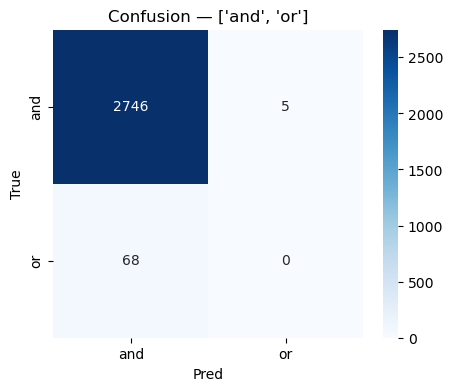


=== Stage 2: learning ['nand', 'nor'] ===
  Epoch 01, loss_new: 6.0247
  Epoch 10, loss_new: 2.2143
  Epoch 50, loss_new: 0.9329
  → Acc on group 1 ['and', 'or']: 77.78%
  → Acc on group 2 ['nand', 'nor']: 50.37%


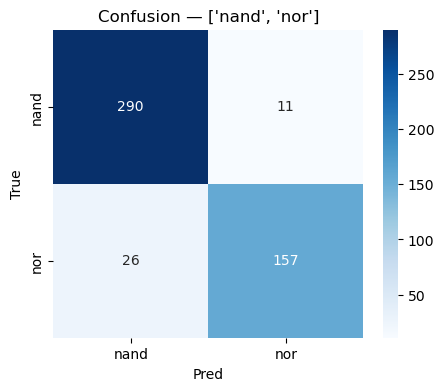


=== Stage 3: learning ['xor'] ===
  Epoch 01, loss_new: 21.8302
  Epoch 10, loss_new: 0.5829
  Epoch 50, loss_new: 0.4649
  → Acc on group 1 ['and', 'or']: 80.83%
  → Acc on group 2 ['nand', 'nor']: 49.81%
  → Acc on group 3 ['xor']: 68.00%


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


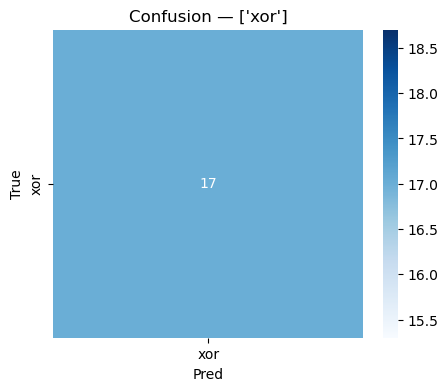


=== Stage 4: learning ['not'] ===
  Epoch 01, loss_new: 0.5814
  Epoch 10, loss_new: 0.5306
  Epoch 50, loss_new: 0.4391
  → Acc on group 1 ['and', 'or']: 82.54%
  → Acc on group 2 ['nand', 'nor']: 48.69%
  → Acc on group 3 ['xor']: 68.00%
  → Acc on group 4 ['not']: 78.44%


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


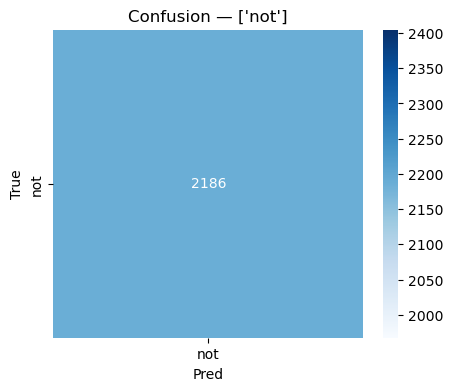


=== Test accuracies per stage & group ===
      group_1 group_2 group_3 group_4
Stage                                
1      72.78%    nan%    nan%    nan%
2      77.78%  50.37%    nan%    nan%
3      80.83%  49.81%  68.00%    nan%
4      82.54%  48.69%  68.00%  78.44%

=== A-GEM Interpretability: Cosine Sim vs Forgetting ===
  from_to   cos_sim  delta_acc
0     1→2 -0.846356  -0.049950
1     1→3 -0.180219  -0.080476
2     2→3 -0.294312   0.005607
3     1→4  0.608224  -0.097522
4     2→4 -0.476724   0.016822
5     3→4 -0.628591   0.000000

Correlation (cosine similarity vs ΔAcc): -0.6079

=== A-GEM Interpretability: Param Drift vs Forgetting ===
  from_to  param_drift  delta_acc
0     1→2     7.674234  -0.049950
1     1→3     9.632319  -0.080476
2     2→3     5.137197   0.005607
3     1→4    10.177646  -0.097522
4     2→4     5.789945   0.016822
5     3→4     2.109867   0.000000

Correlation (param drift vs ΔAcc): -0.8663


In [34]:
import copy
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import dgl
import dgl.nn as dglnn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------
# 1. Load & preprocess data
# ------------------------------------------------
df = pd.read_csv("all_circuits_features.csv")
le = LabelEncoder()
df["gate_label"] = le.fit_transform(df["gate_type"].astype(str))

feat_cols = [
    "fan_in","fan_out","dist_to_output",
    "is_primary_input","is_primary_output","is_internal","is_key_gate",
    "degree_centrality","betweenness_centrality",
    "closeness_centrality","clustering_coefficient",
    "avg_fan_in_neighbors","avg_fan_out_neighbors"
]
df = df.dropna(subset=feat_cols)
df[feat_cols] = StandardScaler().fit_transform(df[feat_cols].astype(float))

nodes = df["node"].tolist()
node2idx = {n:i for i,n in enumerate(nodes)}
N = len(nodes)

# ------------------------------------------------
# 2. Build DGL graph
# ------------------------------------------------
edges = []
src_cands = df[df["fan_out"]>0]["node"].tolist()
for _, row in df.iterrows():
    tgt = node2idx[row["node"]]
    for s in src_cands[:int(row["fan_in"])]:
        edges.append((node2idx[s], tgt))
edges = list(set(edges))
src, dst = zip(*edges) if edges else ([],[])
graph = dgl.graph((torch.tensor(src), torch.tensor(dst)), num_nodes=N)
graph = dgl.add_self_loop(graph)
graph.ndata["feat"]  = torch.tensor(df[feat_cols].values, dtype=torch.float32)
graph.ndata["label"] = torch.tensor(df["gate_label"].values, dtype=torch.long)

# ------------------------------------------------
# 3. Define tasks by gate‐type groups
# ------------------------------------------------
group_defs = [
    ["and","or"],
    ["nand","nor"],
    ["xor","xnor"],
    ["buf","not"]
]
all_types = set(df["gate_type"])
valid_groups, train_masks, test_masks = [], [], []
for grp in group_defs:
    present = [g for g in grp if g in all_types]
    if not present: continue
    valid_groups.append(present)
    idxs = [node2idx[n] for n in df[df["gate_type"].isin(present)]["node"]]
    tr, te = train_test_split(idxs, test_size=0.2, random_state=42)
    tm = torch.zeros((N,), dtype=torch.bool); tm[tr]=True
    vm = torch.zeros((N,), dtype=torch.bool); vm[te]=True
    train_masks.append(tm); test_masks.append(vm)

# ------------------------------------------------
# 4. Define GCN
# ------------------------------------------------
class GCN(nn.Module):
    def __init__(self, in_feats, hid, num_cls):
        super().__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hid, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hid,   num_cls, allow_zero_in_degree=True)
    def forward(self, g, x):
        h = torch.relu(self.conv1(g, x))
        return self.conv2(g, h)

# ------------------------------------------------
# 5. Helper: flatten & set grads
# ------------------------------------------------
def get_grad_vector(params):
    return torch.cat([p.grad.data.view(-1) for p in params])

def set_grad_vector(params, vec):
    pointer = 0
    for p in params:
        numel = p.numel()
        p.grad.data.copy_(vec[pointer:pointer+numel].view_as(p))
        pointer += numel

# ------------------------------------------------
# 6. Training loop w/ A-GEM + snapshots
# ------------------------------------------------
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model         = GCN(len(feat_cols), 64, len(le.classes_)).to(device)
opt           = optim.Adam(model.parameters(), lr=1e-2)
criterion     = nn.CrossEntropyLoss()
graph         = graph.to(device)

memory_buffer = []      # all exemplars seen so far
memory_snap   = []      # copy of memory_buffer after each stage
param_snapshots = []    # parameter state_dict per stage
results       = {}

memory_per_task = 200
mem_batch_size  = 100

for stage, (tr_mask, te_mask, grp) in enumerate(
        zip(train_masks, test_masks, valid_groups), start=1):
    print(f"\n=== Stage {stage}: learning {grp} ===")
    tr_mask = tr_mask.to(device)
    te_mask = te_mask.to(device)
    new_idxs = tr_mask.nonzero().squeeze().tolist()
    params = [p for p in model.parameters() if p.requires_grad]

    model.train()
    for epoch in range(1, 51):
        # 1) reference gradient on memory
        if memory_buffer:
            mem_idxs = random.sample(memory_buffer,
                                     min(mem_batch_size, len(memory_buffer)))
            opt.zero_grad()
            logits = model(graph, graph.ndata["feat"])
            loss_mem = criterion(logits[mem_idxs], graph.ndata["label"][mem_idxs])
            loss_mem.backward()
            g_ref = get_grad_vector(params).clone()

        # 2) gradient on new task
        opt.zero_grad()
        logits = model(graph, graph.ndata["feat"])
        loss_new = criterion(logits[new_idxs], graph.ndata["label"][new_idxs])
        loss_new.backward()
        g_new = get_grad_vector(params).clone()

        # 3) A-GEM projection
        if memory_buffer:
            dot = torch.dot(g_new, g_ref)
            if dot < 0:
                g_proj = g_new - dot / (g_ref.dot(g_ref) + 1e-12) * g_ref
                set_grad_vector(params, g_proj)

        opt.step()
        if epoch in (1, 10, 50):
            print(f"  Epoch {epoch:02d}, loss_new: {loss_new.item():.4f}")

    # update memory_buffer & snapshot it
    sampled = random.sample(new_idxs, min(memory_per_task, len(new_idxs)))
    memory_buffer.extend(sampled)
    memory_snap.append(memory_buffer.copy())

    # evaluation
    model.eval()
    with torch.no_grad():
        logits_full = model(graph, graph.ndata["feat"]).cpu().numpy()
        preds       = logits_full.argmax(axis=1)
        results[stage] = {}
        for i in range(stage):
            idxs = test_masks[i].nonzero().squeeze().cpu().numpy()
            acc = accuracy_score(graph.ndata["label"][idxs].cpu().numpy(), preds[idxs])
            results[stage][f"group_{i+1}"] = acc
            print(f"  → Acc on group {i+1} {valid_groups[i]}: {acc*100:.2f}%")
        cm_idxs = te_mask.nonzero().squeeze().cpu().numpy()
        cm = confusion_matrix(
            graph.ndata["label"][cm_idxs].cpu().numpy(),
            preds[cm_idxs],
            labels=le.transform(grp)
        )
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=grp, yticklabels=grp)
        plt.title(f"Confusion — {grp}")
        plt.xlabel("Pred"); plt.ylabel("True")
        plt.show()

    # snapshot parameters after this stage
    param_snapshots.append({
        k: v.clone().detach().cpu()
        for k, v in model.state_dict().items()
    })

# ------------------------------------------------
# 7. Summarize results
# ------------------------------------------------
df_res = pd.DataFrame(results).T
df_res.index.name = "Stage"
print("\n=== Test accuracies per stage & group ===")
print(df_res.applymap(lambda v: f"{v*100:5.2f}%"))

# ------------------------------------------------
# 8. Interpretability Dashboard for A-GEM
# ------------------------------------------------
# (a) Cosine similarity vs forgetting
records = []
num_tasks = len(memory_snap)
for t in range(2, num_tasks + 1):
    # new-task gradient at t
    model.zero_grad()
    tr_idxs_t = train_masks[t-1].nonzero().squeeze().tolist()
    logits_t  = model(graph, graph.ndata["feat"])
    loss_new_t = criterion(logits_t[tr_idxs_t], graph.ndata["label"][tr_idxs_t])
    loss_new_t.backward()
    g_new_t = get_grad_vector([p for p in model.parameters() if p.requires_grad]).cpu()

    for k in range(1, t):
        # reference gradient for k
        model.zero_grad()
        mem_k = memory_snap[k-1]
        logits_k = model(graph, graph.ndata["feat"])
        loss_mem_k = criterion(logits_k[mem_k], graph.ndata["label"][mem_k])
        loss_mem_k.backward()
        g_ref_k = get_grad_vector([p for p in model.parameters() if p.requires_grad]).cpu()

        cos_sim = torch.dot(g_new_t, g_ref_k) / (
            g_new_t.norm() * g_ref_k.norm() + 1e-12
        )
        delta_acc = results[k][f"group_{k}"] - results[t][f"group_{k}"]
        records.append({
            "from_task": k, "to_task": t,
            "cos_sim": cos_sim.item(),
            "delta_acc": delta_acc
        })

agem_df = pd.DataFrame(records)
agem_df["from_to"] = agem_df.apply(lambda r: f"{int(r['from_task'])}→{int(r['to_task'])}", axis=1)
print("\n=== A-GEM Interpretability: Cosine Sim vs Forgetting ===")
print(agem_df[["from_to","cos_sim","delta_acc"]])
print(f"\nCorrelation (cosine similarity vs ΔAcc): {agem_df['cos_sim'].corr(agem_df['delta_acc']):.4f}")

# (b) Parameter drift vs forgetting
drift_records = []
for t in range(2, len(param_snapshots)+1):
    state_t = param_snapshots[t-1]
    for k in range(1, t):
        state_k = param_snapshots[k-1]
        sqnorm = 0.0
        for name in state_k:
            diff = state_t[name] - state_k[name]
            sqnorm += diff.pow(2).sum().item()
        param_drift = np.sqrt(sqnorm)
        delta_acc = results[k][f"group_{k}"] - results[t][f"group_{k}"]
        drift_records.append({
            "from_task": k, "to_task": t,
            "param_drift": param_drift,
            "delta_acc": delta_acc
        })

drift_df = pd.DataFrame(drift_records)
drift_df["from_to"] = drift_df.apply(lambda r: f"{int(r['from_task'])}→{int(r['to_task'])}", axis=1)
print("\n=== A-GEM Interpretability: Param Drift vs Forgetting ===")
print(drift_df[["from_to","param_drift","delta_acc"]])
print(f"\nCorrelation (param drift vs ΔAcc): {drift_df['param_drift'].corr(drift_df['delta_acc']):.4f}")


#### Hybrid: Meta-Experience Replay (MER)
    -Combines experience replay with meta-gradient optimization.


=== Stage 1: learning ['and', 'or'] ===
  Epoch 01, loss_new: 2.1035
  Epoch 10, loss_new: 1.9671
  Epoch 50, loss_new: 1.5707
  → Acc on group 1 ['and', 'or']: 79.54%


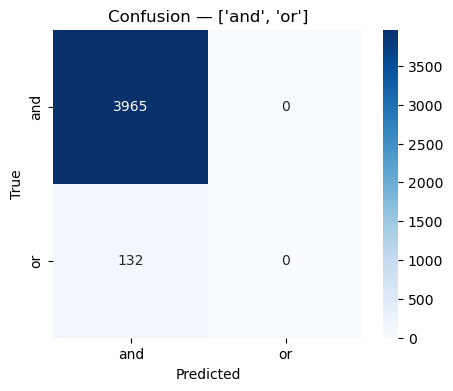


=== Stage 2: learning ['nand', 'nor'] ===
  Epoch 01, loss_new: 2.3551
  Epoch 10, loss_new: 2.3662
  Epoch 50, loss_new: 2.4088
  → Acc on group 1 ['and', 'or']: 79.33%
  → Acc on group 2 ['nand', 'nor']: 5.61%


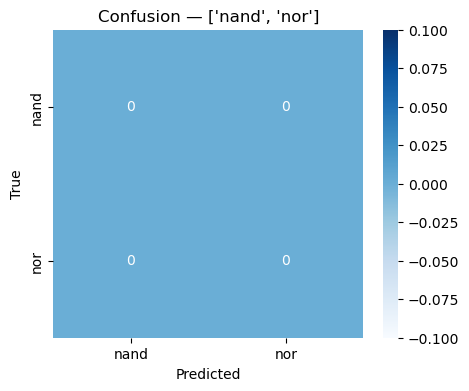


=== Stage 3: learning ['xor'] ===
  Epoch 01, loss_new: 4.6032
  Epoch 10, loss_new: 4.6756
  Epoch 50, loss_new: 4.5033
  → Acc on group 1 ['and', 'or']: 79.41%
  → Acc on group 2 ['nand', 'nor']: 20.28%
  → Acc on group 3 ['xor']: 0.00%


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


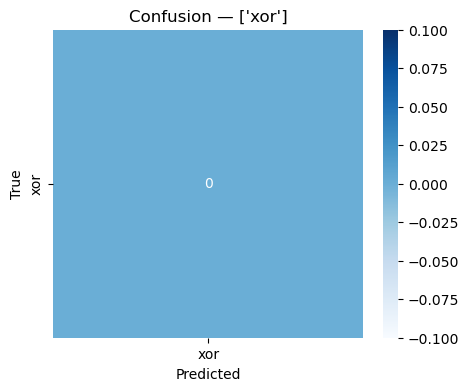


=== Stage 4: learning ['not'] ===
  Epoch 01, loss_new: 1.7582
  Epoch 10, loss_new: 1.7407
  Epoch 50, loss_new: 1.7285
  → Acc on group 1 ['and', 'or']: 79.62%
  → Acc on group 2 ['nand', 'nor']: 21.78%
  → Acc on group 3 ['xor']: 68.00%
  → Acc on group 4 ['not']: 27.69%


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


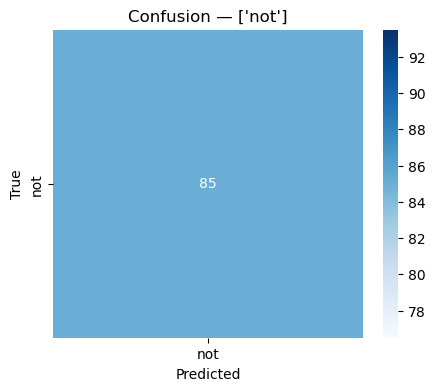


=== Test accuracies per stage & group ===
      group_1 group_2 group_3 group_4
Stage                                
1      79.54%    nan%    nan%    nan%
2      79.33%   5.61%    nan%    nan%
3      79.41%  20.28%   0.00%    nan%
4      79.62%  21.78%  68.00%  27.69%


In [35]:
import copy
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import dgl
import dgl.nn as dglnn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------
# 1. Load & preprocess data
# ------------------------------------------------
df = pd.read_csv("all_circuits_features.csv")

le = LabelEncoder()
df["gate_label"] = le.fit_transform(df["gate_type"].astype(str))

feat_cols = [
    "fan_in","fan_out","dist_to_output",
    "is_primary_input","is_primary_output","is_internal","is_key_gate",
    "degree_centrality","betweenness_centrality",
    "closeness_centrality","clustering_coefficient",
    "avg_fan_in_neighbors","avg_fan_out_neighbors"
]
df = df.dropna(subset=feat_cols)
df[feat_cols] = StandardScaler().fit_transform(df[feat_cols].astype(float))

nodes = df["node"].tolist()
node2idx = {n:i for i,n in enumerate(nodes)}
N = len(nodes)

# ------------------------------------------------
# 2. Build single DGL graph
# ------------------------------------------------
edges = []
src_cands = df[df["fan_out"]>0]["node"].tolist()
for _, row in df.iterrows():
    tgt = node2idx[row["node"]]
    k   = int(row["fan_in"])
    for s in src_cands[:k]:
        edges.append((node2idx[s], tgt))
edges = list(set(edges))
src, dst = zip(*edges) if edges else ([],[])
graph = dgl.graph((torch.tensor(src), torch.tensor(dst)), num_nodes=N)
graph = dgl.add_self_loop(graph)
graph.ndata["feat"]  = torch.tensor(df[feat_cols].values, dtype=torch.float32)
graph.ndata["label"] = torch.tensor(df["gate_label"].values, dtype=torch.long)

# ------------------------------------------------
# 3. Define tasks by gate‐type groups
# ------------------------------------------------
group_defs = [
    ["and","or"], ["nand","nor"],
    ["xor","xnor"], ["buf","not"]
]
all_types = set(df["gate_type"])
valid_groups, train_masks, test_masks = [], [], []
for grp in group_defs:
    present = [g for g in grp if g in all_types]
    if not present: continue
    valid_groups.append(present)
    idxs = [node2idx[n] for n in df[df["gate_type"].isin(present)]["node"]]
    tr, te = train_test_split(idxs, test_size=0.2, random_state=42)
    tm = torch.zeros((N,), dtype=torch.bool); tm[tr]=True
    vm = torch.zeros((N,), dtype=torch.bool); vm[te]=True
    train_masks.append(tm); test_masks.append(vm)

# ------------------------------------------------
# 4. Define GCN
# ------------------------------------------------
class GCN(nn.Module):
    def __init__(self, in_feats, hid, num_cls):
        super().__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hid, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hid,   num_cls, allow_zero_in_degree=True)
    def forward(self, g, x):
        h = torch.relu(self.conv1(g, x))
        return self.conv2(g, h)

# ------------------------------------------------
# 5. Meta-Experience Replay (MER) training
# ------------------------------------------------
memory_buffer    = []        # stores exemplars across tasks
memory_per_task  = 200       # max samples per task
mer_batch_size   = 64        # for both new and memory
inner_lr         = 0.005     # lr for inner update
meta_lr          = 0.01      # lr for meta-update

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = GCN(len(feat_cols), 64, len(le.classes_)).to(device)
opt    = optim.SGD(model.parameters(), lr=meta_lr)
criterion = nn.CrossEntropyLoss()
graph = graph.to(device)

results = {}

for stage, (tr_mask, te_mask, grp) in enumerate(
    zip(train_masks, test_masks, valid_groups), 1):
    print(f"\n=== Stage {stage}: learning {grp} ===")
    tr_mask = tr_mask.to(device)
    te_mask = te_mask.to(device)

    new_idxs = tr_mask.nonzero().squeeze().tolist()

    # TRAIN current task with MER
    model.train()
    for epoch in range(1, 51):
        # sample minibatch from new task
        new_batch = random.sample(new_idxs, min(mer_batch_size, len(new_idxs)))
        # sample minibatch from memory
        mem_batch = (random.sample(memory_buffer, mer_batch_size)
                     if len(memory_buffer)>=mer_batch_size else memory_buffer.copy())

        # --- MER meta-update ---
        opt.zero_grad()
        # 1) Compute grad on new batch
        logits_new = model(graph, graph.ndata["feat"])
        loss_new   = criterion(logits_new[new_batch],
                               graph.ndata["label"][new_batch].to(device))
        grads_new  = torch.autograd.grad(loss_new, model.parameters(), create_graph=True)

        # 2) Inner update: theta' = theta - inner_lr * grad_new
        theta_orig = [p.data.clone() for p in model.parameters()]
        for p, g in zip(model.parameters(), grads_new):
            p.data.sub_(inner_lr * g.data)

        # 3) Compute loss on memory batch with updated params
        if mem_batch:
            logits_mem = model(graph, graph.ndata["feat"])
            loss_mem   = criterion(logits_mem[mem_batch],
                                   graph.ndata["label"][mem_batch].to(device))
            # 4) Meta-grad: d loss_mem / d theta
            grads_meta = torch.autograd.grad(loss_mem, model.parameters())
        else:
            grads_meta = grads_new  # fallback to new grads if no memory

        # restore original parameters
        for p, v in zip(model.parameters(), theta_orig):
            p.data.copy_(v)

        # 5) Apply meta-gradient update
        for p, g_meta in zip(model.parameters(), grads_meta):
            p.grad = g_meta.data.clone()
        opt.step()

        if epoch in (1, 10, 50):
            print(f"  Epoch {epoch:02d}, loss_new: {loss_new.item():.4f}")

    # update memory buffer with random subset of this task
    sampled = random.sample(new_idxs, min(memory_per_task, len(new_idxs)))
    memory_buffer.extend(sampled)

    # EVALUATE on all seen tasks
    model.eval()
    with torch.no_grad():
        logits = model(graph, graph.ndata["feat"]).cpu().numpy()
        preds  = logits.argmax(axis=1)
        results[stage] = {}
        for i in range(stage):
            mask  = test_masks[i]
            idxs  = mask.nonzero().squeeze().cpu().numpy()
            acc   = accuracy_score(graph.ndata["label"][idxs].cpu().numpy(),
                                   preds[idxs])
            results[stage][f"group_{i+1}"] = acc
            print(f"  → Acc on group {i+1} {valid_groups[i]}: {acc*100:.2f}%")

        # confusion matrix for current group
        cm_idxs = te_mask.nonzero().squeeze().cpu().numpy()
        cm = confusion_matrix(
            graph.ndata["label"][cm_idxs].cpu().numpy(),
            preds[cm_idxs],
            labels=le.transform(grp)
        )
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=grp, yticklabels=grp)
        plt.title(f"Confusion — {grp}")
        plt.xlabel("Predicted"); plt.ylabel("True")
        plt.show()

# ------------------------------------------------
# 6. Summarize results
# ------------------------------------------------
df_res = pd.DataFrame(results).T
df_res.index.name = "Stage"
print("\n=== Test accuracies per stage & group ===")
print(df_res.applymap(lambda v: f"{v*100:5.2f}%"))


##### Interpretability Dashboard


=== Stage 1: learning ['and', 'or'] ===
  Epoch 01, loss_new: 2.1582
  Epoch 10, loss_new: 1.9968
  Epoch 50, loss_new: 1.6489
  → Acc on group 1 ['and', 'or']: 76.97%


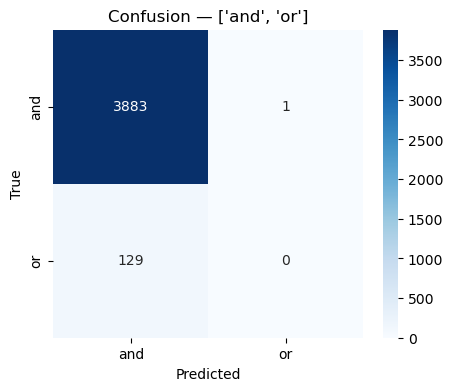


=== Stage 2: learning ['nand', 'nor'] ===
  Epoch 01, loss_new: 2.2361
  Epoch 10, loss_new: 2.3799
  Epoch 50, loss_new: 2.5937
  → Acc on group 1 ['and', 'or']: 78.79%
  → Acc on group 2 ['nand', 'nor']: 5.61%


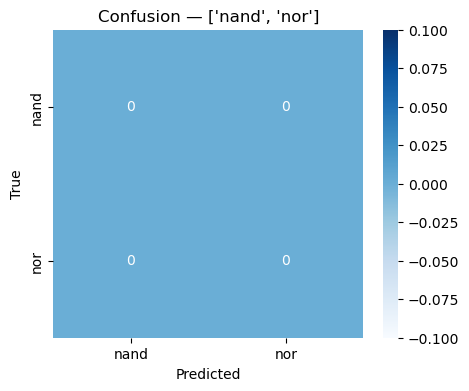


=== Stage 3: learning ['xor'] ===
  Epoch 01, loss_new: 6.3227
  Epoch 10, loss_new: 6.1152
  Epoch 50, loss_new: 5.4837
  → Acc on group 1 ['and', 'or']: 78.71%
  → Acc on group 2 ['nand', 'nor']: 20.28%
  → Acc on group 3 ['xor']: 0.00%


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


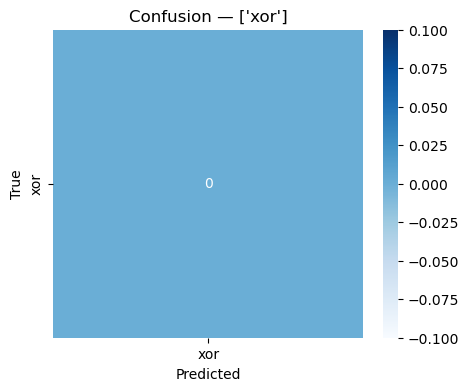


=== Stage 4: learning ['not'] ===
  Epoch 01, loss_new: 1.9962
  Epoch 10, loss_new: 2.1198
  Epoch 50, loss_new: 1.9850
  → Acc on group 1 ['and', 'or']: 78.69%
  → Acc on group 2 ['nand', 'nor']: 20.28%
  → Acc on group 3 ['xor']: 68.00%
  → Acc on group 4 ['not']: 25.63%


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


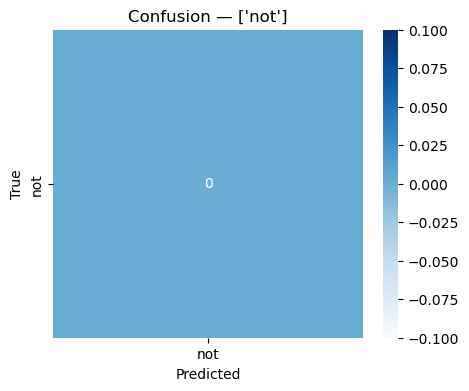


=== Test accuracies per stage & group ===
      group_1 group_2 group_3 group_4
Stage                                
1      76.97%    nan%    nan%    nan%
2      78.79%   5.61%    nan%    nan%
3      78.71%  20.28%   0.00%    nan%
4      78.69%  20.28%  68.00%  25.63%

=== MER Interpretability: Meta-Drift vs Forgetting ===
  from_to  meta_drift  delta_acc
0     1→2    0.167610  -0.018236
1     1→3    0.371546  -0.017443
2     2→3    0.162565  -0.146729
3     1→4    0.696586  -0.017245
4     2→4    0.453386  -0.146729
5     3→4    0.164472  -0.680000

Correlation (meta_drift vs ΔAcc): 0.4363


In [36]:
import copy
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import dgl
import dgl.nn as dglnn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------
# 1. Load & preprocess data
# ------------------------------------------------
df = pd.read_csv("all_circuits_features.csv")
le = LabelEncoder()
df["gate_label"] = le.fit_transform(df["gate_type"].astype(str))

feat_cols = [
    "fan_in","fan_out","dist_to_output",
    "is_primary_input","is_primary_output","is_internal","is_key_gate",
    "degree_centrality","betweenness_centrality",
    "closeness_centrality","clustering_coefficient",
    "avg_fan_in_neighbors","avg_fan_out_neighbors"
]
df = df.dropna(subset=feat_cols)
df[feat_cols] = StandardScaler().fit_transform(df[feat_cols].astype(float))

nodes = df["node"].tolist()
node2idx = {n:i for i,n in enumerate(nodes)}
N = len(nodes)

# ------------------------------------------------
# 2. Build single DGL graph
# ------------------------------------------------
edges = []
src_cands = df[df["fan_out"]>0]["node"].tolist()
for _, row in df.iterrows():
    tgt = node2idx[row["node"]]
    k   = int(row["fan_in"])
    for s in src_cands[:k]:
        edges.append((node2idx[s], tgt))
edges = list(set(edges))
src, dst = zip(*edges) if edges else ([],[])
graph = dgl.graph((torch.tensor(src), torch.tensor(dst)), num_nodes=N)
graph = dgl.add_self_loop(graph)
graph.ndata["feat"]  = torch.tensor(df[feat_cols].values, dtype=torch.float32)
graph.ndata["label"] = torch.tensor(df["gate_label"].values, dtype=torch.long)

# ------------------------------------------------
# 3. Define tasks by gate‐type groups
# ------------------------------------------------
group_defs = [
    ["and","or"], ["nand","nor"],
    ["xor","xnor"], ["buf","not"]
]
all_types = set(df["gate_type"])
valid_groups, train_masks, test_masks = [], [], []
for grp in group_defs:
    present = [g for g in grp if g in all_types]
    if not present: continue
    valid_groups.append(present)
    idxs = [node2idx[n] for n in df[df["gate_type"].isin(present)]["node"]]
    tr, te = train_test_split(idxs, test_size=0.2, random_state=42)
    tm = torch.zeros((N,), dtype=torch.bool); tm[tr]=True
    vm = torch.zeros((N,), dtype=torch.bool); vm[te]=True
    train_masks.append(tm); test_masks.append(vm)

# ------------------------------------------------
# 4. Define GCN
# ------------------------------------------------
class GCN(nn.Module):
    def __init__(self, in_feats, hid, num_cls):
        super().__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hid, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hid,   num_cls, allow_zero_in_degree=True)
    def forward(self, g, x):
        h = torch.relu(self.conv1(g, x))
        return self.conv2(g, h)

# ------------------------------------------------
# 5. Meta-Experience Replay (MER) training
# ------------------------------------------------
memory_buffer    = []        # stores exemplars across tasks
memory_per_task  = 200       # max samples per task
mer_batch_size   = 64        # for both new and memory
inner_lr         = 0.005     # lr for inner update
meta_lr          = 0.01      # lr for meta-update

device         = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model          = GCN(len(feat_cols), 64, len(le.classes_)).to(device)
opt            = optim.SGD(model.parameters(), lr=meta_lr)
criterion      = nn.CrossEntropyLoss()
graph          = graph.to(device)

results        = {}
param_snapshots = []  # to store θ^(t) after each stage

for stage, (tr_mask, te_mask, grp) in enumerate(
    zip(train_masks, test_masks, valid_groups), 1):
    print(f"\n=== Stage {stage}: learning {grp} ===")
    tr_mask = tr_mask.to(device)
    te_mask = te_mask.to(device)

    new_idxs = tr_mask.nonzero().squeeze().tolist()

    # TRAIN current task with MER
    model.train()
    for epoch in range(1, 51):
        # sample minibatch from new task
        new_batch = random.sample(new_idxs, min(mer_batch_size, len(new_idxs)))
        # sample minibatch from memory
        mem_batch = (random.sample(memory_buffer, mer_batch_size)
                     if len(memory_buffer)>=mer_batch_size else memory_buffer.copy())

        # --- MER meta-update ---
        opt.zero_grad()
        # 1) Compute grad on new batch
        logits_new = model(graph, graph.ndata["feat"])
        loss_new   = criterion(logits_new[new_batch],
                               graph.ndata["label"][new_batch].to(device))
        grads_new  = torch.autograd.grad(loss_new, model.parameters(), create_graph=True)

        # 2) Inner update: θ′ = θ − α ∇L_new
        theta_orig = [p.data.clone() for p in model.parameters()]
        for p, g in zip(model.parameters(), grads_new):
            p.data.sub_(inner_lr * g.data)

        # 3) Compute loss on memory batch with updated params
        if mem_batch:
            logits_mem = model(graph, graph.ndata["feat"])
            loss_mem   = criterion(logits_mem[mem_batch],
                                   graph.ndata["label"][mem_batch].to(device))
            # 4) Meta-grad: d loss_mem / d θ
            grads_meta = torch.autograd.grad(loss_mem, model.parameters())
        else:
            grads_meta = grads_new  # fallback

        # restore original θ
        for p, v in zip(model.parameters(), theta_orig):
            p.data.copy_(v)

        # 5) Apply meta-gradient update
        for p, g_meta in zip(model.parameters(), grads_meta):
            p.grad = g_meta.data.clone()
        opt.step()

        if epoch in (1, 10, 50):
            print(f"  Epoch {epoch:02d}, loss_new: {loss_new.item():.4f}")

    # update memory buffer for this task
    sampled = random.sample(new_idxs, min(memory_per_task, len(new_idxs)))
    memory_buffer.extend(sampled)

    # EVALUATE on all seen tasks
    model.eval()
    with torch.no_grad():
        logits = model(graph, graph.ndata["feat"]).cpu().numpy()
        preds  = logits.argmax(axis=1)
        results[stage] = {}
        for i in range(stage):
            idxs  = test_masks[i].nonzero().squeeze().cpu().numpy()
            acc   = accuracy_score(graph.ndata["label"][idxs].cpu().numpy(), preds[idxs])
            results[stage][f"group_{i+1}"] = acc
            print(f"  → Acc on group {i+1} {valid_groups[i]}: {acc*100:.2f}%")

        cm_idxs = te_mask.nonzero().squeeze().cpu().numpy()
        cm = confusion_matrix(
            graph.ndata["label"][cm_idxs].cpu().numpy(),
            preds[cm_idxs],
            labels=le.transform(grp)
        )
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=grp, yticklabels=grp)
        plt.title(f"Confusion — {grp}")
        plt.xlabel("Predicted"); plt.ylabel("True")
        plt.show()

    # snapshot parameters θ^(stage)
    param_snapshots.append({
        name: tensor.clone().detach().cpu()
        for name, tensor in model.state_dict().items()
    })

# ------------------------------------------------
# 6. Summarize results
# ------------------------------------------------
df_res = pd.DataFrame(results).T
df_res.index.name = "Stage"
print("\n=== Test accuracies per stage & group ===")
print(df_res.applymap(lambda v: f"{v*100:5.2f}%"))

# ------------------------------------------------
# 7. Interpretability Dashboard for MER
# ------------------------------------------------
records = []
num_tasks = len(param_snapshots)

for t in range(2, num_tasks+1):
    state_t = param_snapshots[t-1]
    for k in range(1, t):
        state_k = param_snapshots[k-1]

        # Meta‐drift: Σ_i (θ_i^(t) − θ_i^(k))²
        meta_drift = 0.0
        for name in state_k:
            diff = state_t[name] - state_k[name]
            meta_drift += diff.pow(2).sum().item()

        # Forgetting ΔAcc_k^(t)
        acc_kk = results[k][f"group_{k}"]
        acc_kt = results[t][f"group_{k}"]
        delta_acc = acc_kk - acc_kt

        records.append({
            "from_task":  k,
            "to_task":    t,
            "meta_drift": meta_drift,
            "delta_acc":  delta_acc
        })

mer_df = pd.DataFrame(records)
mer_df["from_to"] = mer_df.apply(lambda r: f"{int(r['from_task'])}→{int(r['to_task'])}", axis=1)

# Print the dashboard
print("\n=== MER Interpretability: Meta-Drift vs Forgetting ===")
print(mer_df[["from_to","meta_drift","delta_acc"]])

# Correlation
corr_md = mer_df["meta_drift"].corr(mer_df["delta_acc"])
print(f"\nCorrelation (meta_drift vs ΔAcc): {corr_md:.4f}")


In [37]:
# ------------------------------------------------
# 9. Additional: Parameter Drift vs Forgetting for MER
# ------------------------------------------------
import numpy as np
import pandas as pd

drift_records = []
# param_snapshots was built in your MER loop
for t in range(2, len(param_snapshots) + 1):
    state_t = param_snapshots[t-1]
    for k in range(1, t):
        state_k = param_snapshots[k-1]

        # compute L2 parameter drift ‖θ^(t) − θ^(k)‖₂
        sq = 0.0
        for name in state_k:
            diff = state_t[name] - state_k[name]
            sq += diff.pow(2).sum().item()
        param_drift = np.sqrt(sq)

        # compute forgetting ΔAcc_k^(t)
        acc_kk = results[k][f"group_{k}"]
        acc_kt = results[t][f"group_{k}"]
        delta_acc = acc_kk - acc_kt

        drift_records.append({
            "from_task":   k,
            "to_task":     t,
            "param_drift": param_drift,
            "delta_acc":   delta_acc
        })

drift_df = pd.DataFrame(drift_records)
drift_df["from_to"] = drift_df.apply(
    lambda r: f"{int(r['from_task'])}→{int(r['to_task'])}", axis=1
)

print("\n=== MER Interpretability: Param Drift vs Forgetting ===")
print(drift_df[["from_to","param_drift","delta_acc"]])

corr_pd = drift_df["param_drift"].corr(drift_df["delta_acc"])
print(f"\nCorrelation (param drift vs ΔAcc): {corr_pd:.4f}")



=== MER Interpretability: Param Drift vs Forgetting ===
  from_to  param_drift  delta_acc
0     1→2     0.409402  -0.018236
1     1→3     0.609546  -0.017443
2     2→3     0.403193  -0.146729
3     1→4     0.834617  -0.017245
4     2→4     0.673339  -0.146729
5     3→4     0.405551  -0.680000

Correlation (param drift vs ΔAcc): 0.4513


#### Hybrid: CoPE
- Combines continual learning with self-supervised pretraining.

Global self-supervised pretraining...
  [Global Pre] 1/50, loss: 1.2398
  [Global Pre] 25/50, loss: 0.9322
  [Global Pre] 50/50, loss: 1.0258

=== Stage 1: CoPE on ['and', 'or'] ===
  [Pre1] 1/50, loss: 1.0902
  [Pre1] 25/50, loss: 0.6077
  [Pre1] 50/50, loss: 0.2592
  [Cls1] 1/100, loss: 2.0160
  [Cls1] 50/100, loss: 0.7071
  [Cls1] 100/100, loss: 0.6755
  → Acc group 1 ['and', 'or']: 69.39%


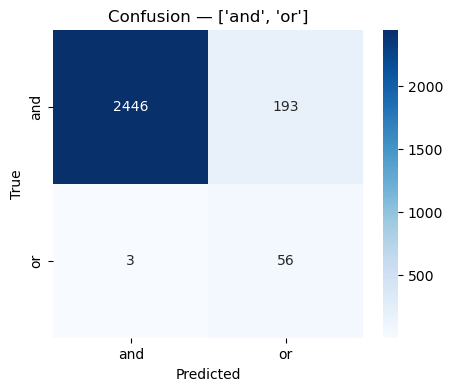


=== Stage 2: CoPE on ['nand', 'nor'] ===
  [Pre2] 1/50, loss: 3.5119
  [Pre2] 25/50, loss: 0.1674
  [Pre2] 50/50, loss: 0.1090
  [Cls2] 1/100, loss: 3.4828
  [Cls2] 50/100, loss: 0.6404
  [Cls2] 100/100, loss: 0.5638
  → Acc group 1 ['and', 'or']: 43.58%
  → Acc group 2 ['nand', 'nor']: 77.24%


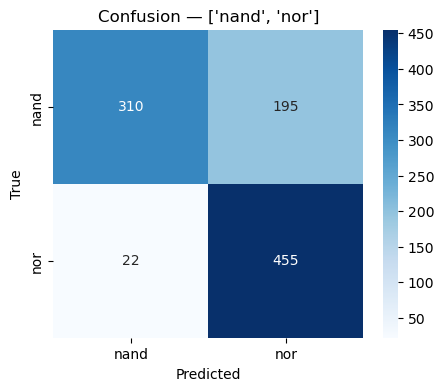


=== Stage 3: CoPE on ['xor'] ===
  [Pre3] 1/50, loss: 5.2343
  [Pre3] 25/50, loss: 230.6622
  [Pre3] 50/50, loss: 1.3608
  [Cls3] 1/100, loss: 38.7175
  [Cls3] 50/100, loss: 0.0028
  [Cls3] 100/100, loss: 0.0047
  → Acc group 1 ['and', 'or']: 29.93%
  → Acc group 2 ['nand', 'nor']: 23.69%
  → Acc group 3 ['xor']: 100.00%


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


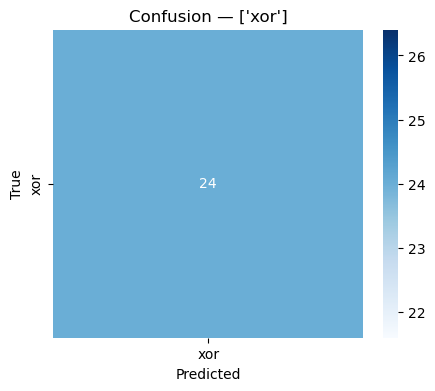


=== Stage 4: CoPE on ['not'] ===
  [Pre4] 1/50, loss: 0.7648
  [Pre4] 25/50, loss: 0.7486
  [Pre4] 50/50, loss: 0.6361
  [Cls4] 1/100, loss: 4.4461
  [Cls4] 50/100, loss: 0.5431
  [Cls4] 100/100, loss: 0.4976
  → Acc group 1 ['and', 'or']: 84.17%
  → Acc group 2 ['nand', 'nor']: 24.98%
  → Acc group 3 ['xor']: 70.83%
  → Acc group 4 ['not']: 78.78%


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


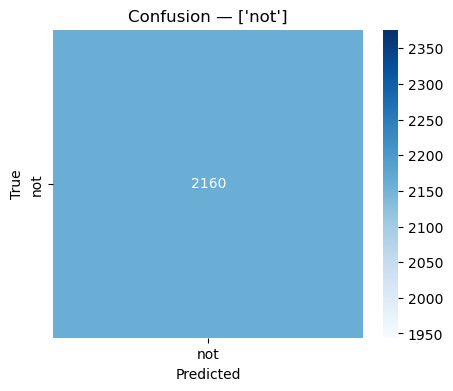


=== Test accuracies per stage & group ===
      group_1 group_2  group_3 group_4
Stage                                 
1      69.39%    nan%     nan%    nan%
2      43.58%  77.24%     nan%    nan%
3      29.93%  23.69%  100.00%    nan%
4      84.17%  24.98%   70.83%  78.78%


In [18]:
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import dgl
import dgl.nn as dglnn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------
# 1. Load & preprocess data
# ------------------------------------------------
df = pd.read_csv("all_circuits_features.csv")
le = LabelEncoder()
df["gate_label"] = le.fit_transform(df["gate_type"].astype(str))

feat_cols = [
    "fan_in","fan_out","dist_to_output",
    "is_primary_input","is_primary_output","is_internal","is_key_gate",
    "degree_centrality","betweenness_centrality",
    "closeness_centrality","clustering_coefficient",
    "avg_fan_in_neighbors","avg_fan_out_neighbors"
]
df = df.dropna(subset=feat_cols)
df[feat_cols] = StandardScaler().fit_transform(df[feat_cols].astype(float))

nodes = df["node"].tolist()
node2idx = {n: i for i, n in enumerate(nodes)}
N = len(nodes)

# ------------------------------------------------
# 2. Build the DGL graph
# ------------------------------------------------
edges = []
src_cands = df[df["fan_out"] > 0]["node"].tolist()
for _, row in df.iterrows():
    tgt = node2idx[row["node"]]
    for src in src_cands[: int(row["fan_in"])]:
        edges.append((node2idx[src], tgt))
edges = list(set(edges))
src, dst = zip(*edges) if edges else ([], [])
graph = dgl.graph((torch.tensor(src), torch.tensor(dst)), num_nodes=N)
graph = dgl.add_self_loop(graph)
graph.ndata["feat"]  = torch.tensor(df[feat_cols].values, dtype=torch.float32)
graph.ndata["label"] = torch.tensor(df["gate_label"].values, dtype=torch.long)

# ------------------------------------------------
# 3. Define tasks by gate‐type groups
# ------------------------------------------------
group_defs = [
    ["and","or"], ["nand","nor"],
    ["xor","xnor"], ["buf","not"]
]
all_types = set(df["gate_type"])
valid_groups, train_masks, test_masks = [], [], []

for grp in group_defs:
    present = [g for g in grp if g in all_types]
    if not present:
        continue
    valid_groups.append(present)
    idxs = [node2idx[n] for n in df[df["gate_type"].isin(present)]["node"]]
    strat = df["gate_label"].iloc[idxs]
    tr, te = train_test_split(idxs, test_size=0.2, random_state=42, stratify=strat)
    tm = torch.zeros((N,), dtype=torch.bool); tm[tr] = True
    vm = torch.zeros((N,), dtype=torch.bool); vm[te] = True
    train_masks.append(tm); test_masks.append(vm)

# ------------------------------------------------
# 4. CoPE model with BatchNorm & Dropout
# ------------------------------------------------
class CoPEModel(nn.Module):
    def __init__(self, in_feats, hid, num_cls, drop=0.5):
        super().__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hid, allow_zero_in_degree=True)
        self.bn1   = nn.BatchNorm1d(hid)
        self.conv2 = dglnn.GraphConv(hid,     hid, allow_zero_in_degree=True)
        self.bn2   = nn.BatchNorm1d(hid)
        self.drop  = nn.Dropout(drop)
        self.classifier   = nn.Linear(hid, num_cls)
        self.pretext_head = nn.Linear(hid, in_feats)

    def encode(self, g, x):
        h = F.relu(self.bn1(self.conv1(g, x)))
        h = self.drop(h)
        h = F.relu(self.bn2(self.conv2(g, h)))
        return self.drop(h)

    def forward(self, g, x):
        return self.classifier(self.encode(g, x))

    def reconstruct(self, g, x):
        return self.pretext_head(self.encode(g, x))

# ------------------------------------------------
# 5. CoPE training with improved class‐weighting
# ------------------------------------------------
device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model    = CoPEModel(len(feat_cols), hid=128,
                     num_cls=len(le.classes_), drop=0.4).to(device)
graph    = graph.to(device)
feats    = graph.ndata["feat"]

opt_pre = optim.Adam(
    list(model.conv1.parameters()) + list(model.bn1.parameters()) +
    list(model.conv2.parameters()) + list(model.bn2.parameters()) +
    list(model.pretext_head.parameters()),
    lr=5e-4, weight_decay=1e-5
)
opt_cls = optim.Adam(
    list(model.conv1.parameters()) + list(model.bn1.parameters()) +
    list(model.conv2.parameters()) + list(model.bn2.parameters()) +
    list(model.classifier.parameters()),
    lr=5e-3, weight_decay=1e-5
)

results    = {}
mask_ratio = 0.2
pre_epochs = 50
cls_epochs = 100
num_cls    = len(le.classes_)

# Global self-supervised warm‐up
print("Global self-supervised pretraining...")
for epoch in range(1, pre_epochs+1):
    model.train()
    masked = feats.clone()
    dims = np.random.choice(feats.shape[1],
                            int(mask_ratio * feats.shape[1]), replace=False)
    masked[:, dims] = 0
    recon    = model.reconstruct(graph, masked)
    loss_pre = F.mse_loss(recon[:, dims], feats[:, dims])
    opt_pre.zero_grad(); loss_pre.backward(); opt_pre.step()
    if epoch in (1, 25, pre_epochs):
        print(f"  [Global Pre] {epoch}/{pre_epochs}, loss: {loss_pre:.4f}")

# Stage‐wise CoPE
for stage, (tr_mask, te_mask, grp) in enumerate(
    zip(train_masks, test_masks, valid_groups), start=1):
    print(f"\n=== Stage {stage}: CoPE on {grp} ===")
    tr_idxs = tr_mask.nonzero().squeeze().tolist()
    te_idxs = te_mask.nonzero().squeeze().tolist()

    # 1) Task‐specific self‐supervised pretraining
    for epoch in range(1, pre_epochs+1):
        model.train()
        masked = feats.clone()
        dims   = np.random.choice(feats.shape[1],
                                  int(mask_ratio * feats.shape[1]), replace=False)
        masked[tr_idxs][:, dims] = 0
        recon    = model.reconstruct(graph, masked)
        loss_pre = F.mse_loss(recon[tr_idxs][:, dims], feats[tr_idxs][:, dims])
        opt_pre.zero_grad(); loss_pre.backward(); opt_pre.step()
        if epoch in (1, 25, pre_epochs):
            print(f"  [Pre{stage}] {epoch}/{pre_epochs}, loss: {loss_pre:.4f}")

    # 2) Supervised fine‐tuning with balanced per‐class weights
    # Compute weight vector of length `num_cls`
    label_tr = graph.ndata["label"][tr_mask].to(device)
    counts   = torch.bincount(label_tr, minlength=num_cls).float()
    # avoid division by zero and cap max weight
    weights = (label_tr.numel() / (counts * num_cls)).clamp(max=10.0)
    weights[counts == 0] = 0.0
    criterion = nn.CrossEntropyLoss(weight=weights)

    for epoch in range(1, cls_epochs+1):
        model.train()
        logits = model(graph, feats)
        loss   = criterion(logits[tr_idxs], label_tr)
        opt_cls.zero_grad(); loss.backward(); opt_cls.step()
        if epoch in (1, 50, cls_epochs):
            print(f"  [Cls{stage}] {epoch}/{cls_epochs}, loss: {loss:.4f}")

    # 3) Evaluation on all seen tasks
    model.eval()
    with torch.no_grad():
        logits = model(graph, feats).cpu().numpy()
        preds  = logits.argmax(axis=1)
        results[stage] = {}
        for i in range(stage):
            idxs = test_masks[i].nonzero().squeeze().cpu().numpy()
            acc  = accuracy_score(
                graph.ndata["label"][idxs].cpu().numpy(), preds[idxs]
            )
            results[stage][f"group_{i+1}"] = acc
            print(f"  → Acc group {i+1} {valid_groups[i]}: {acc*100:.2f}%")

        cm = confusion_matrix(
            graph.ndata["label"][te_idxs].cpu().numpy(),
            preds[te_idxs],
            labels=le.transform(grp)
        )
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=grp, yticklabels=grp)
        plt.title(f"Confusion — {grp}")
        plt.xlabel("Predicted"); plt.ylabel("True")
        plt.show()

# ------------------------------------------------
# 6. Results summary
# ------------------------------------------------
df_res = pd.DataFrame(results).T
df_res.index.name = "Stage"
print("\n=== Test accuracies per stage & group ===")
print(df_res.applymap(lambda v: f"{v*100:5.2f}%"))


##### Interpretability Dashboard

Global self-supervised pretraining...
  [Global Pre] 1/50, loss: 1.2976
  [Global Pre] 25/50, loss: 1.1278
  [Global Pre] 50/50, loss: 0.9652

=== Stage 1: CoPE on ['and', 'or'] ===
  [Pre1] 1/50, loss: 0.4954
  [Pre1] 25/50, loss: 0.0471
  [Pre1] 50/50, loss: 0.3850
  [Cls1] 1/100, loss: 2.1820
  [Cls1] 50/100, loss: 0.7120
  [Cls1] 100/100, loss: 0.6754
  → Acc group 1 ['and', 'or']: 59.07%


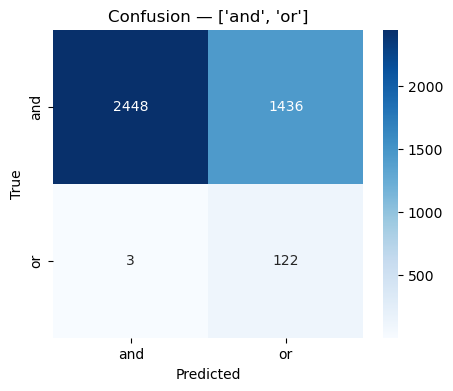


=== Stage 2: CoPE on ['nand', 'nor'] ===
  [Pre2] 1/50, loss: 3.4909
  [Pre2] 25/50, loss: 0.2901
  [Pre2] 50/50, loss: 1.7583
  [Cls2] 1/100, loss: 3.3602
  [Cls2] 50/100, loss: 0.6405
  [Cls2] 100/100, loss: 0.5692
  → Acc group 1 ['and', 'or']: 43.86%
  → Acc group 2 ['nand', 'nor']: 77.33%


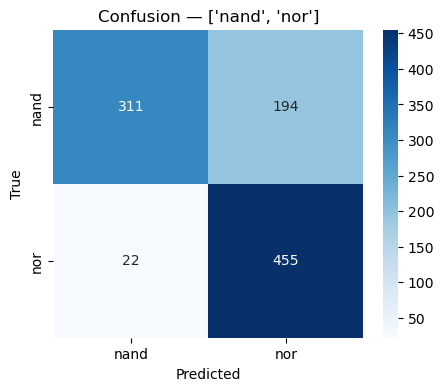


=== Stage 3: CoPE on ['xor'] ===
  [Pre3] 1/50, loss: 2.3435
  [Pre3] 25/50, loss: 4.9601
  [Pre3] 50/50, loss: 1.5651
  [Cls3] 1/100, loss: 48.5533
  [Cls3] 50/100, loss: 0.0031
  [Cls3] 100/100, loss: 0.0069
  → Acc group 1 ['and', 'or']: 25.44%
  → Acc group 2 ['nand', 'nor']: 23.13%
  → Acc group 3 ['xor']: 100.00%


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


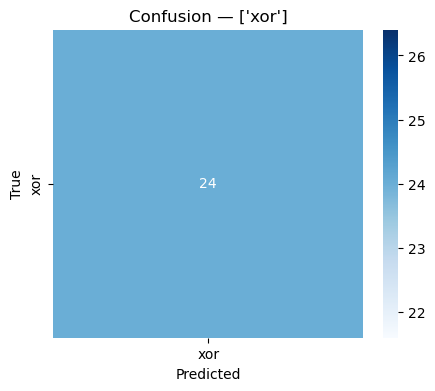


=== Stage 4: CoPE on ['not'] ===
  [Pre4] 1/50, loss: 0.4113
  [Pre4] 25/50, loss: 0.5011
  [Pre4] 50/50, loss: 0.5702
  [Cls4] 1/100, loss: 5.3428
  [Cls4] 50/100, loss: 0.5257
  [Cls4] 100/100, loss: 0.4921
  → Acc group 1 ['and', 'or']: 84.57%
  → Acc group 2 ['nand', 'nor']: 24.06%
  → Acc group 3 ['xor']: 70.83%
  → Acc group 4 ['not']: 78.78%


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


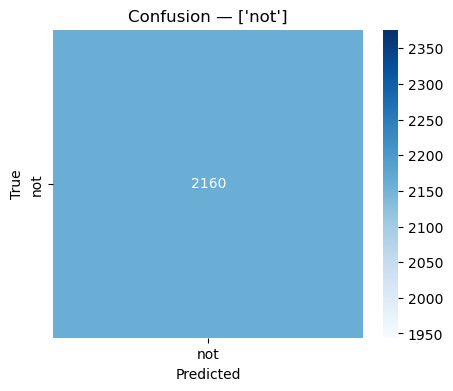


=== Test accuracies per stage & group ===
      group_1 group_2  group_3 group_4
Stage                                 
1      59.07%    nan%     nan%    nan%
2      43.86%  77.33%     nan%    nan%
3      25.44%  23.13%  100.00%    nan%
4      84.57%  24.06%   70.83%  78.78%

=== CoPE: Param Drift vs Forgetting ===
   from_to  param_drift  delta_acc
0  1.0→2.0   214.918384   0.152135
1  1.0→3.0   475.515659   0.336340
2  2.0→3.0   284.320540   0.541935
3  1.0→4.0   691.005168  -0.254961
4  2.0→4.0   490.250261   0.532719
5  3.0→4.0   250.576836   0.291667
Correlation: -0.5044

=== CoPE: CoPE‐Shift vs Forgetting ===
   from_to  cope_shift  delta_acc
0  1.0→2.0    0.292325   0.152135
1  1.0→3.0    0.548116   0.336340
2  2.0→3.0    0.432877   0.541935
3  1.0→4.0    0.568473  -0.254961
4  2.0→4.0    0.475173   0.532719
5  3.0→4.0    0.193288   0.291667
Correlation: -0.1891


In [38]:
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import dgl
import dgl.nn as dglnn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------
# 1. Load & preprocess data
# ------------------------------------------------
df = pd.read_csv("all_circuits_features.csv")
le = LabelEncoder()
df["gate_label"] = le.fit_transform(df["gate_type"].astype(str))

feat_cols = [
    "fan_in","fan_out","dist_to_output",
    "is_primary_input","is_primary_output","is_internal","is_key_gate",
    "degree_centrality","betweenness_centrality",
    "closeness_centrality","clustering_coefficient",
    "avg_fan_in_neighbors","avg_fan_out_neighbors"
]
df = df.dropna(subset=feat_cols)
df[feat_cols] = StandardScaler().fit_transform(df[feat_cols].astype(float))

nodes = df["node"].tolist()
node2idx = {n: i for i, n in enumerate(nodes)}
N = len(nodes)

# ------------------------------------------------
# 2. Build the DGL graph
# ------------------------------------------------
edges = []
src_cands = df[df["fan_out"] > 0]["node"].tolist()
for _, row in df.iterrows():
    tgt = node2idx[row["node"]]
    for src in src_cands[: int(row["fan_in"])]:
        edges.append((node2idx[src], tgt))
edges = list(set(edges))
src, dst = zip(*edges) if edges else ([], [])
graph = dgl.graph((torch.tensor(src), torch.tensor(dst)), num_nodes=N)
graph = dgl.add_self_loop(graph)
graph.ndata["feat"]  = torch.tensor(df[feat_cols].values, dtype=torch.float32)
graph.ndata["label"] = torch.tensor(df["gate_label"].values, dtype=torch.long)

# ------------------------------------------------
# 3. Define tasks by gate‐type groups
# ------------------------------------------------
group_defs = [
    ["and","or"], ["nand","nor"],
    ["xor","xnor"], ["buf","not"]
]
all_types = set(df["gate_type"])
valid_groups, train_masks, test_masks = [], [], []
for grp in group_defs:
    present = [g for g in grp if g in all_types]
    if not present: continue
    valid_groups.append(present)
    idxs = [node2idx[n] for n in df[df["gate_type"].isin(present)]["node"]]
    strat = df["gate_label"].iloc[idxs]
    tr, te = train_test_split(idxs, test_size=0.2, random_state=42, stratify=strat)
    tm = torch.zeros((N,), dtype=torch.bool); tm[tr] = True
    vm = torch.zeros((N,), dtype=torch.bool); vm[te] = True
    train_masks.append(tm); test_masks.append(vm)

# ------------------------------------------------
# 4. CoPE model with BatchNorm & Dropout
# ------------------------------------------------
class CoPEModel(nn.Module):
    def __init__(self, in_feats, hid, num_cls, drop=0.5):
        super().__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hid, allow_zero_in_degree=True)
        self.bn1   = nn.BatchNorm1d(hid)
        self.conv2 = dglnn.GraphConv(hid,     hid, allow_zero_in_degree=True)
        self.bn2   = nn.BatchNorm1d(hid)
        self.drop  = nn.Dropout(drop)
        self.classifier   = nn.Linear(hid, num_cls)
        self.pretext_head = nn.Linear(hid, in_feats)

    def encode(self, g, x):
        h = F.relu(self.bn1(self.conv1(g, x)))
        h = self.drop(h)
        h = F.relu(self.bn2(self.conv2(g, h)))
        return self.drop(h)

    def forward(self, g, x):
        return self.classifier(self.encode(g, x))

    def reconstruct(self, g, x):
        return self.pretext_head(self.encode(g, x))

# ------------------------------------------------
# 5. CoPE training with snapshotting
# ------------------------------------------------
device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model    = CoPEModel(len(feat_cols), hid=128,
                     num_cls=len(le.classes_), drop=0.4).to(device)
graph    = graph.to(device)
feats    = graph.ndata["feat"]

opt_pre = optim.Adam(
    list(model.conv1.parameters()) + list(model.bn1.parameters()) +
    list(model.conv2.parameters()) + list(model.bn2.parameters()) +
    list(model.pretext_head.parameters()),
    lr=5e-4, weight_decay=1e-5
)
opt_cls = optim.Adam(
    list(model.conv1.parameters()) + list(model.bn1.parameters()) +
    list(model.conv2.parameters()) + list(model.bn2.parameters()) +
    list(model.classifier.parameters()),
    lr=5e-3, weight_decay=1e-5
)

results      = {}
mask_ratio   = 0.2
pre_epochs   = 50
cls_epochs   = 100
num_cls      = len(le.classes_)

# snapshot lists
param_snapshots     = []
pretext_snapshots   = []

# global self‐supervised warm‐up (no snapshot)
print("Global self-supervised pretraining...")
for epoch in range(1, pre_epochs+1):
    model.train()
    masked = feats.clone()
    dims   = np.random.choice(feats.shape[1],
                              int(mask_ratio * feats.shape[1]), replace=False)
    masked[:, dims] = 0
    recon    = model.reconstruct(graph, masked)
    loss_pre = F.mse_loss(recon[:, dims], feats[:, dims])
    opt_pre.zero_grad(); loss_pre.backward(); opt_pre.step()
    if epoch in (1, 25, pre_epochs):
        print(f"  [Global Pre] {epoch}/{pre_epochs}, loss: {loss_pre:.4f}")

# stage‐wise CoPE
for stage, (tr_mask, te_mask, grp) in enumerate(
    zip(train_masks, test_masks, valid_groups), start=1):

    tr_idxs = tr_mask.nonzero().squeeze().tolist()
    te_idxs = te_mask.nonzero().squeeze().tolist()

    print(f"\n=== Stage {stage}: CoPE on {grp} ===")

    # 1) task‐specific self‐supervised pretraining
    for epoch in range(1, pre_epochs+1):
        model.train()
        masked = feats.clone()
        dims   = np.random.choice(feats.shape[1],
                                  int(mask_ratio * feats.shape[1]), replace=False)
        masked[tr_idxs][:, dims] = 0
        recon    = model.reconstruct(graph, masked)
        loss_pre = F.mse_loss(recon[tr_idxs][:, dims], feats[tr_idxs][:, dims])
        opt_pre.zero_grad(); loss_pre.backward(); opt_pre.step()
        if epoch in (1, 25, pre_epochs):
            print(f"  [Pre{stage}] {epoch}/{pre_epochs}, loss: {loss_pre:.4f}")

    # 2) supervised fine‐tuning
    label_tr = graph.ndata["label"][tr_mask].to(device)
    counts   = torch.bincount(label_tr, minlength=num_cls).float()
    weights  = (label_tr.numel() / (counts * num_cls)).clamp(max=10.0)
    weights[counts == 0] = 0.0
    criterion = nn.CrossEntropyLoss(weight=weights)

    for epoch in range(1, cls_epochs+1):
        model.train()
        logits = model(graph, feats)
        loss   = criterion(logits[tr_idxs], label_tr)
        opt_cls.zero_grad(); loss.backward(); opt_cls.step()
        if epoch in (1, 50, cls_epochs):
            print(f"  [Cls{stage}] {epoch}/{cls_epochs}, loss: {loss:.4f}")

    # 3) evaluation
    model.eval()
    with torch.no_grad():
        logits  = model(graph, feats).cpu().numpy()
        preds   = logits.argmax(axis=1)
        results[stage] = {}
        for i in range(stage):
            idxs = test_masks[i].nonzero().squeeze().cpu().numpy()
            acc  = accuracy_score(
                graph.ndata["label"][idxs].cpu().numpy(), preds[idxs]
            )
            results[stage][f"group_{i+1}"] = acc
            print(f"  → Acc group {i+1} {valid_groups[i]}: {acc*100:.2f}%")

        # confusion
        cm = confusion_matrix(
            graph.ndata["label"][te_idxs].cpu().numpy(),
            preds[te_idxs],
            labels=le.transform(grp)
        )
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=grp, yticklabels=grp)
        plt.title(f"Confusion — {grp}")
        plt.xlabel("Predicted"); plt.ylabel("True")
        plt.show()

    # --- snapshots after stage ---
    # 1) full parameters θ^(stage)
    param_snapshots.append({
        name: param.clone().detach().cpu()
        for name, param in model.state_dict().items()
    })
    # 2) pretext‐head parameters f_self^(stage)
    pretext_snapshots.append({
        name: param.clone().detach().cpu()
        for name, param in model.pretext_head.state_dict().items()
    })

# ------------------------------------------------
# 6. Results summary
# ------------------------------------------------
df_res = pd.DataFrame(results).T
df_res.index.name = "Stage"
print("\n=== Test accuracies per stage & group ===")
print(df_res.applymap(lambda v: f"{v*100:5.2f}%"))

# ------------------------------------------------
# 7. Interpretability Dashboard for CoPE
# ------------------------------------------------

# A) Parameter‐Drift vs Forgetting
drift_records = []
for t in range(2, len(param_snapshots)+1):
    θ_t = param_snapshots[t-1]
    for k in range(1, t):
        θ_k = param_snapshots[k-1]
        sq   = 0.0
        for name in θ_k:
            d   = θ_t[name] - θ_k[name]
            sq += d.pow(2).sum().item()
        drift = np.sqrt(sq)
        delta = results[k][f"group_{k}"] - results[t][f"group_{k}"]
        drift_records.append({
            "from_task": k, "to_task": t,
            "param_drift": drift, "delta_acc": delta
        })
drift_df = pd.DataFrame(drift_records)
drift_df["from_to"] = drift_df.apply(lambda r: f"{r.from_task}→{r.to_task}", axis=1)
print("\n=== CoPE: Param Drift vs Forgetting ===")
print(drift_df[["from_to","param_drift","delta_acc"]])
print(f"Correlation: {drift_df.param_drift.corr(drift_df.delta_acc):.4f}")

# B) CoPE‐Shift vs Forgetting (pretext‐head drift)
cope_records = []
for t in range(2, len(pretext_snapshots)+1):
    head_t = pretext_snapshots[t-1]
    for k in range(1, t):
        head_k = pretext_snapshots[k-1]
        sq     = 0.0
        for name in head_k:
            d   = head_t[name] - head_k[name]
            sq += d.pow(2).sum().item()
        shift = np.sqrt(sq)
        delta = results[k][f"group_{k}"] - results[t][f"group_{k}"]
        cope_records.append({
            "from_task": k, "to_task": t,
            "cope_shift": shift, "delta_acc": delta
        })
cope_df = pd.DataFrame(cope_records)
cope_df["from_to"] = cope_df.apply(lambda r: f"{r.from_task}→{r.to_task}", axis=1)
print("\n=== CoPE: CoPE‐Shift vs Forgetting ===")
print(cope_df[["from_to","cope_shift","delta_acc"]])
print(f"Correlation: {cope_df.cope_shift.corr(cope_df.delta_acc):.4f}")
